# Neuronexus Whisker Stimulation Analysis
## 処理フロー 3~4分
1. **読み込み** - データ読み込み & チャンネル並び替え
2. **ノイズ処理** - フィルタリング（全データ）→ Trim → モーションアーティファクト除去
3. **処理の確認** - 可視化
4. **データ解析** - パワースペクトル & バンド比較

---
## 1. 読み込み

**注意** .plxと.mp4の名前は完全に一致させ、同じフォルダー内に入れて下さい

In [1]:
import neo
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import signal
from scipy.ndimage import binary_dilation
from sklearn.decomposition import FastICA
import seaborn as sns
import pywt
from get_path import get_path
import os
import pandas as pd

PLX_FILE = get_path(mode='file', file_type='plx')
VIDEO_FILE = os.path.splitext(PLX_FILE)[0] + '.mp4'
OUTPUT_DIR = os.path.dirname(PLX_FILE)

BASENAME = os.path.splitext(os.path.basename(PLX_FILE))[0]

# チャンネル並び順 (surface -> deep)
CHANNEL_ORDER = [8, 7, 9, 6, 12, 3, 11, 4, 14, 1, 15, 0, 13, 2, 10, 5]

 選択: 260114-6_Wildtype_S1BF_positoin2_700_wisker.plx


In [2]:
# データ読み込み
plx = neo.io.PlexonIO(filename=PLX_FILE)
data = plx.read()
seg = data[0].segments[0]

# 信号取得 & チャンネル並び替え
ai_raw = seg.analogsignals[0]
lfp_raw = np.array(seg.analogsignals[1][:, CHANNEL_ORDER])
spikes_raw = seg.analogsignals[2][:, CHANNEL_ORDER]
fs = int(seg.analogsignals[1].sampling_rate)
lfp_times_full = np.arange(len(lfp_raw)) / fs

print(f"AI: {ai_raw.shape}, LFP: {lfp_raw.shape}, Spikes: {spikes_raw.shape}")
print(f"サンプリングレート: LFP={fs}Hz")
print(f"記録時間: {lfp_times_full[-1]:.1f}秒")

Parsing signal channels: 100%|██████████| 128/128 [00:00<?, ?it/s]
Parsing spike channels: 16it [00:00, ?it/s]
Parsing event channels: 100%|██████████| 43/43 [00:00<?, ?it/s]


AI: (115205, 2), LFP: (115229, 16), Spikes: (4609119, 16)
サンプリングレート: LFP=1000Hz
記録時間: 115.2秒


In [3]:
# フレーム同期情報を取得（Trim範囲の決定用）
def get_frame_times(events, min_count=1000, max_interval=1.0):
    """フレーム同期イベントを取得し、異常な間隔を除去"""
    for evt in events:
        if len(evt.times) >= min_count:
            times = np.array(evt.times)
            intervals = np.diff(times)
            large_gaps = np.where(intervals > max_interval)[0]
            if len(large_gaps) > 0 and large_gaps[0] < 10:
                times = times[large_gaps[0] + 1:]
            print(f"フレーム同期: {evt.name}, {len(times)}個")
            return times
    raise ValueError("フレーム同期イベントが見つかりません")

frame_times = get_frame_times(seg.events)

# 動画フレーム数と比較
cap = cv2.VideoCapture(VIDEO_FILE)
n_video_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cap.release()

n_sync = min(len(frame_times), n_video_frames)
frame_times = frame_times[:n_sync]

# Trim範囲を決定（まだ切り出さない）
TRIM_START = frame_times[0]
TRIM_END = frame_times[-1]

print(f"同期フレーム数: {n_sync}")
print(f"Trim範囲: {TRIM_START:.2f}s ~ {TRIM_END:.2f}s")

フレーム同期: EVT03, 1241個
同期フレーム数: 1241
Trim範囲: 6.31s ~ 105.49s


---
## 2. ノイズ処理
**重要**: フィルタリングは全データに対して行い、その後でTrimする（端部効果回避）

In [4]:
def bandpass_notch_filter(data, lowcut, highcut, fs, order=4, notch_freq=None, notch_Q=30):
    """バンドパス + ノッチフィルタ"""
    nyq = 0.5 * fs
    sos = signal.butter(order, [lowcut/nyq, highcut/nyq], btype='bandpass', output='sos')
    filtered = signal.sosfiltfilt(sos, data, axis=0)
    
    if notch_freq is not None:
        notch_freqs = [notch_freq] if not isinstance(notch_freq, (list, tuple)) else notch_freq
        for freq in notch_freqs:
            b, a = signal.iirnotch(freq, notch_Q, fs)
            filtered = signal.filtfilt(b, a, filtered, axis=0)
    return filtered

# 全データに対してフィルタリング（端部効果を避けるため）
print("全データにフィルタ適用中...")
lfp_filtered_full = bandpass_notch_filter(lfp_raw, 0.1, 100, fs, notch_freq=60, notch_Q=60)
print(f"フィルタ適用完了: {lfp_filtered_full.shape}")

全データにフィルタ適用中...
フィルタ適用完了: (115229, 16)


In [5]:
# フィルタ後にTrim
idx_start = int(TRIM_START * fs)
idx_end = int(TRIM_END * fs)

lfp_trimmed = lfp_raw[idx_start:idx_end, :]
lfp_filtered = lfp_filtered_full[idx_start:idx_end, :]
lfp_times = np.arange(len(lfp_filtered)) / fs + TRIM_START
t_duration_full = frame_times[-1] - frame_times[0]

print(f"Trim完了: {lfp_filtered.shape}")
print(f"時間範囲: {lfp_times[0]:.2f}s ~ {lfp_times[-1]:.2f}s")

Trim完了: (99180, 16)
時間範囲: 6.31s ~ 105.49s


In [6]:
# ============================================================
# 2.5 悪いチャンネルの検出・除外
# ============================================================

def detect_bad_channels(lfp_data, threshold=3.0, verbose=True):
    """
    分散が異常に大きい/小さいチャンネルを検出
    
    Parameters:
    -----------
    lfp_data : array (samples, channels)
    threshold : float (MADの何倍を閾値にするか)
    
    Returns:
    --------
    bad_channels : list (深さ順インデックス)
    variances : array
    """
    variances = np.var(lfp_data, axis=0)
    median_var = np.median(variances)
    mad = np.median(np.abs(variances - median_var))
    
    # MADベースの閾値（上下両方）
    upper = median_var + threshold * mad * 1.4826
    lower = median_var - threshold * mad * 1.4826
    
    bad_high = np.where(variances > upper)[0]
    bad_low = np.where(variances < lower)[0]
    bad_channels = list(bad_high) + list(bad_low)
    
    if verbose:
        print("チャンネル分散:")
        for i, v in enumerate(variances):
            orig_ch = CHANNEL_ORDER[i]
            flag = " *** BAD ***" if i in bad_channels else ""
            print(f"  D{i:2d}(Ch{orig_ch:2d}): {v:.6f}{flag}")
        print(f"\n閾値: {lower:.6f} ~ {upper:.6f}")
        print(f"異常チャンネル: {bad_channels if bad_channels else 'なし'}")
    
    return bad_channels, variances

# 検出実行（フィルタ後のデータで）
bad_channels, ch_variances = detect_bad_channels(lfp_filtered, threshold=3.0)

# 良いチャンネルのみ抽出
good_channels = [i for i in range(lfp_filtered.shape[1]) if i not in bad_channels]

# 元のチャンネル番号を保持
original_ch_numbers = [CHANNEL_ORDER[i] for i in good_channels]

# データを更新
lfp_trimmed = lfp_trimmed[:, good_channels]
lfp_filtered = lfp_filtered[:, good_channels]
n_channels = len(good_channels)

print(f"\n除外: D{bad_channels} (元Ch: {[CHANNEL_ORDER[i] for i in bad_channels]})")
print(f"残り {n_channels}ch: {['D'+str(i)+'(Ch'+str(original_ch_numbers[i])+')' for i in range(n_channels)]}")

チャンネル分散:
  D 0(Ch 8): 0.024402
  D 1(Ch 7): 0.021322
  D 2(Ch 9): 0.023357
  D 3(Ch 6): 0.021958
  D 4(Ch12): 0.022734
  D 5(Ch 3): 0.022753
  D 6(Ch11): 0.021905
  D 7(Ch 4): 0.036790 *** BAD ***
  D 8(Ch14): 0.021540
  D 9(Ch 1): 0.023855
  D10(Ch15): 0.021520
  D11(Ch 0): 0.024909
  D12(Ch13): 0.025180
  D13(Ch 2): 0.026189
  D14(Ch10): 0.025073
  D15(Ch 5): 0.026115

閾値: 0.016438 ~ 0.030773
異常チャンネル: [7]

除外: D[7] (元Ch: [4])
残り 15ch: ['D0(Ch8)', 'D1(Ch7)', 'D2(Ch9)', 'D3(Ch6)', 'D4(Ch12)', 'D5(Ch3)', 'D6(Ch11)', 'D7(Ch14)', 'D8(Ch1)', 'D9(Ch15)', 'D10(Ch0)', 'D11(Ch13)', 'D12(Ch2)', 'D13(Ch10)', 'D14(Ch5)']


In [7]:
def analyze_video_motion(video_path, roi=None, threshold=15, blur=5):
    """動画からモーション量を計算"""
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if roi is None:
        ret, frame = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame_bright = cv2.convertScaleAbs(frame, alpha=2.0, beta=50)
        print("ROIを選択 (Enter確定, C取消)")
        roi = cv2.selectROI("Select ROI", frame_bright, fromCenter=False)
        cv2.destroyAllWindows()
    
    x, y, w, h = roi
    prev_gray = None
    motion_values = []
    
    for _ in range(total_frames):
        ret, frame = cap.read()
        if not ret:
            break
        
        gray = cv2.cvtColor(frame[y:y+h, x:x+w], cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (blur, blur), 0)
        
        if prev_gray is not None:
            diff = cv2.absdiff(gray, prev_gray)
            _, thresh = cv2.threshold(diff, threshold, 255, cv2.THRESH_BINARY)
            motion_values.append(np.sum(thresh > 0))
        else:
            motion_values.append(0)
        prev_gray = gray
    
    cap.release()
    return np.array(motion_values), roi

# モーション解析
motion_values, roi = analyze_video_motion(VIDEO_FILE)
print(f"モーション解析完了: {len(motion_values)} フレーム")

ROIを選択 (Enter確定, C取消)
モーション解析完了: 1241 フレーム


In [8]:
def create_noise_mask(motion, frame_times, lfp_times, percentile=75, expand_sec=0.1):
    """モーションからノイズマスク作成"""
    n = min(len(motion), len(frame_times))
    motion_resampled = np.interp(lfp_times, frame_times[:n], motion[:n])
    threshold = np.percentile(motion_resampled, percentile)
    
    mask = motion_resampled > threshold
    expand_samples = int(expand_sec * fs)
    mask = binary_dilation(mask, iterations=expand_samples)
    
    print(f"ノイズ閾値: {threshold:.1f} ({percentile}パーセンタイル)")
    print(f"ノイズ区間: {100*np.sum(mask)/len(mask):.1f}%")
    return mask, motion_resampled, threshold

noise_mask, motion_resampled, motion_threshold = create_noise_mask(
    motion_values, frame_times, lfp_times, percentile=75)

# # ノイズマスクを無効化
# noise_mask[:] = False

ノイズ閾値: 0.0 (75パーセンタイル)
ノイズ区間: 28.3%


In [9]:
# === デバッグ用 ===
print("=== ICA前 ===")
print(f"lfp_filtered shape: {lfp_filtered.shape}")
print(f"bad_channels: {bad_channels}")
print(f"noise_mask sum: {np.sum(noise_mask)}")
print(f"lfp_filtered mean: {np.mean(lfp_filtered):.6f}")
print(f"lfp_filtered std: {np.std(lfp_filtered):.6f}")
# === ここまで ===
    

=== ICA前 ===
lfp_filtered shape: (99180, 15)
bad_channels: [7]
noise_mask sum: 28032
lfp_filtered mean: 0.000068
lfp_filtered std: 0.153365


In [10]:
def remove_artifact_ica(lfp_data, noise_mask, n_components=None, noise_ratio_threshold=2.5, max_remove=3):
    """
    ICAでモーションアーティファクト除去（sources も返す）
    """
    # 標準化
    lfp_mean = np.mean(lfp_data, axis=0)
    lfp_std = np.std(lfp_data, axis=0)
    lfp_std[lfp_std == 0] = 1
    lfp_norm = (lfp_data - lfp_mean) / lfp_std
    
    if n_components is None:
        n_components = lfp_data.shape[1]
    
    print(f"ICA実行中 (n_components={n_components})...")
    ica = FastICA(n_components=n_components, random_state=42, max_iter=1000, tol=0.01)
    sources = ica.fit_transform(lfp_norm)
    
    # ノイズ成分特定
    noise_ratios = []
    for i in range(n_components):
        var_noise = np.var(sources[noise_mask, i])
        var_clean = np.var(sources[~noise_mask, i])
        ratio = var_noise / var_clean if var_clean > 0 else np.inf
        noise_ratios.append(ratio)
    
    # ratioが高い順にソート
    sorted_idx = np.argsort(noise_ratios)[::-1]
    remove_idx = []
    
    print(f"\n成分のノイズ比率 (閾値: {noise_ratio_threshold}):")
    for i in sorted_idx:
        status = ""
        if noise_ratios[i] > noise_ratio_threshold and len(remove_idx) < max_remove:
            remove_idx.append(i)
            status = "→ 除去"
        print(f"  IC{i}: ratio={noise_ratios[i]:.2f} {status}")
    
    # ノイズ成分を除去して再構成
    sources_clean = sources.copy()
    sources_clean[:, remove_idx] = 0
    lfp_reconstructed = ica.inverse_transform(sources_clean) * lfp_std + lfp_mean
    
    print(f"\n除去成分数: {len(remove_idx)}/{n_components}")
    
    return lfp_reconstructed, remove_idx, noise_ratios, sources


# ICA実行 ~20秒で完了
lfp_cleaned, removed_ics, noise_ratios, ica_sources = remove_artifact_ica(
    lfp_filtered, noise_mask, 
    noise_ratio_threshold=1.5,
    max_remove=4
)

ICA実行中 (n_components=15)...

成分のノイズ比率 (閾値: 1.5):
  IC9: ratio=76.18 → 除去
  IC6: ratio=9.67 → 除去
  IC11: ratio=8.04 → 除去
  IC1: ratio=7.08 → 除去
  IC5: ratio=5.84 
  IC14: ratio=3.81 
  IC0: ratio=3.40 
  IC8: ratio=3.23 
  IC10: ratio=2.47 
  IC3: ratio=2.25 
  IC2: ratio=1.93 
  IC12: ratio=1.08 
  IC13: ratio=1.03 
  IC7: ratio=0.99 
  IC4: ratio=0.88 

除去成分数: 4/15


---
## 3. 処理の確認

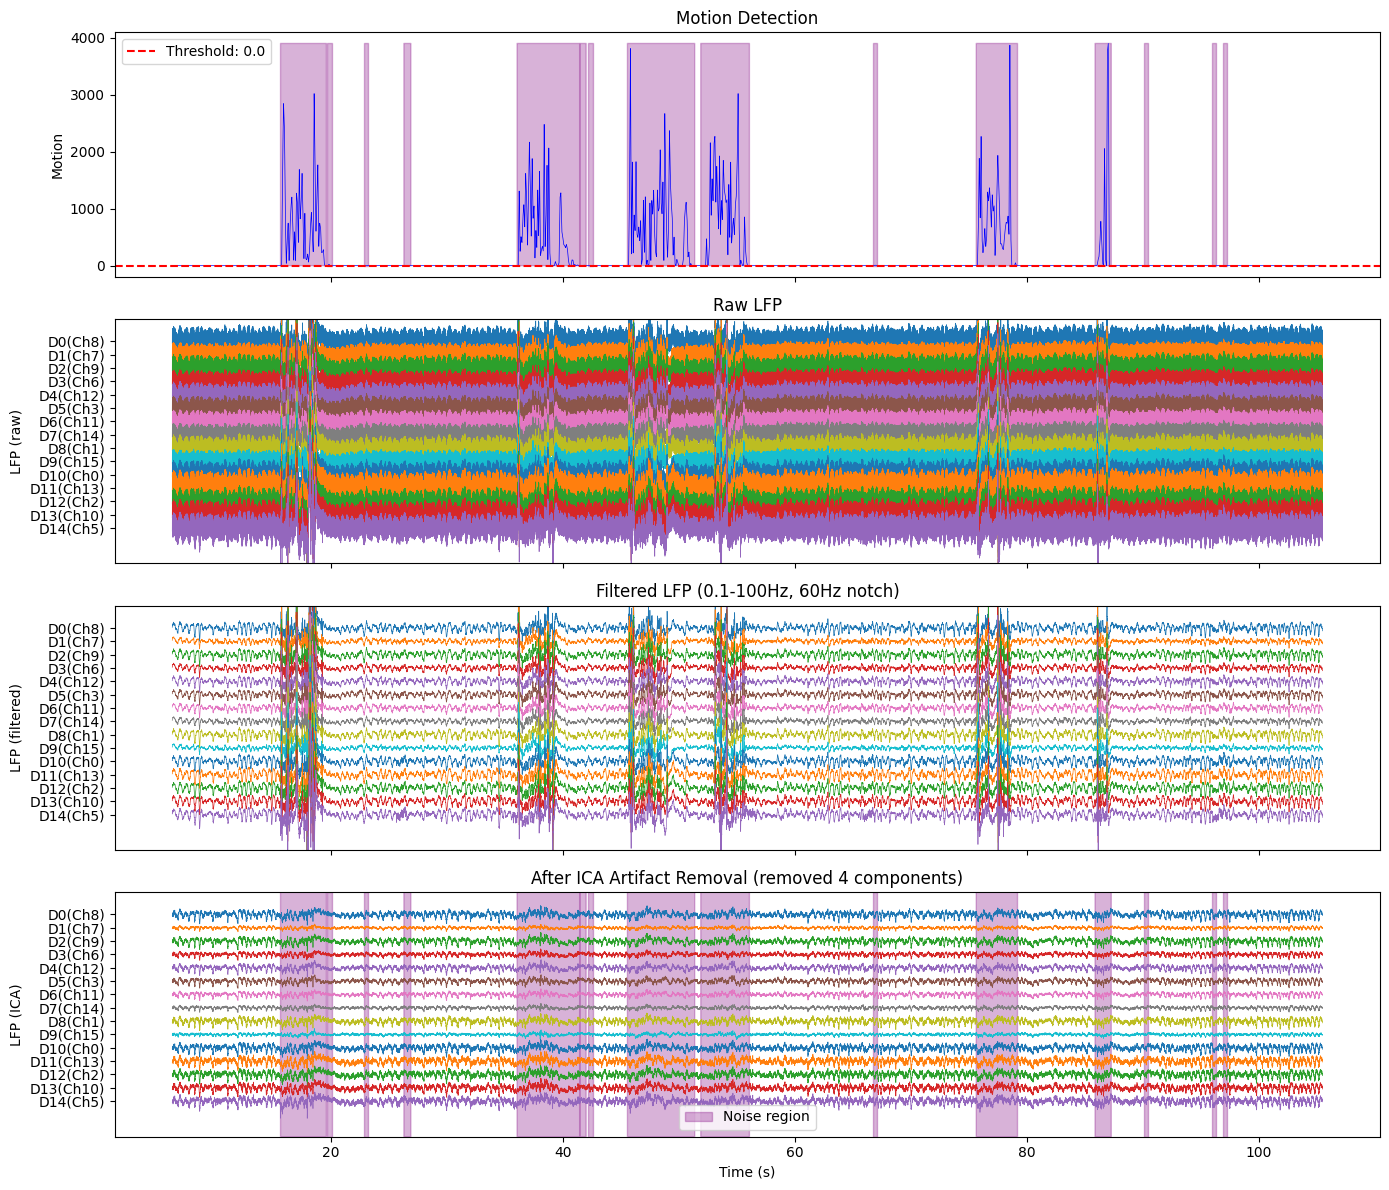

In [11]:
# 処理結果の可視化
t_plot = t_duration_full  # 表示秒数
t_mask = lfp_times < lfp_times[0] + t_plot

fig, axes = plt.subplots(4, 1, figsize=(14, 12), sharex=True)

# モーション
axes[0].plot(lfp_times[t_mask], motion_resampled[t_mask], 'b-', lw=0.5)
axes[0].axhline(motion_threshold, color='r', ls='--', label=f'Threshold: {motion_threshold:.1f}')
axes[0].fill_between(lfp_times[t_mask], 0, motion_resampled[t_mask].max(),
                     where=noise_mask[t_mask], alpha=0.3, color='purple')
axes[0].set_ylabel('Motion')
axes[0].legend()
axes[0].set_title('Motion Detection')

# Raw LFP
for idx in range(lfp_trimmed.shape[1]):
    axes[1].plot(lfp_times[t_mask], lfp_trimmed[t_mask, idx] - idx*0.3, lw=0.5)
axes[1].set_ylabel('LFP (raw)')
axes[1].set_title('Raw LFP')
axes[1].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[1].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

# Filtered LFP
for idx in range(lfp_filtered.shape[1]):
    axes[2].plot(lfp_times[t_mask], lfp_filtered[t_mask, idx] - idx*0.3, lw=0.5)
axes[2].set_ylabel('LFP (filtered)')
axes[2].set_title('Filtered LFP (0.1-100Hz, 60Hz notch)')
axes[2].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[2].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

# ICA Cleaned LFP
for idx in range(lfp_cleaned.shape[1]):
    axes[3].plot(lfp_times[t_mask], lfp_cleaned[t_mask, idx] - idx*0.3, lw=0.5)
axes[3].fill_between(lfp_times[t_mask], -5, 0.5,
                     where=noise_mask[t_mask], alpha=0.3, color='purple', label='Noise region')
axes[3].set_ylabel('LFP (ICA)')
axes[3].set_xlabel('Time (s)')
axes[3].set_title(f'After ICA Artifact Removal (removed {len(removed_ics)} components)')
axes[3].legend()
axes[3].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[3].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

for ax in axes[1:]:
    ax.set_ylim(-5, 0.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_processing_overview.png'), dpi=150)
plt.show()

In [12]:

# 動画 + LFP + モーション同期確認用動画の作成（高速版）

def create_sync_video_fast(video_path, lfp_data, lfp_times, motion_resampled, noise_mask,
                           frame_times, roi, output_path="sync_check.mp4",
                           t_start=None, t_duration=None, channel=0, fps_out=30):
    """
    高速版：Figureを使い回してメモリ効率化
    """
    import cv2
    
    if t_start is None:
        t_start = frame_times[0]
    if t_duration is None:
        t_duration = frame_times[-1] - frame_times[0]
    t_end = t_start + t_duration
    
    # 動画読み込み
    cap = cv2.VideoCapture(video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    start_frame_idx = np.searchsorted(frame_times, t_start)
    end_frame_idx = np.searchsorted(frame_times, t_end)
    total_frames = end_frame_idx - start_frame_idx
    
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_idx)
    
    # プロットサイズ
    fig_width, fig_height = 10, 5
    dpi = 80  # 低めに
    plot_width = int(fig_width * dpi)
    plot_height = int(fig_height * dpi)
    
    total_width = frame_width + plot_width
    total_height = max(frame_height, plot_height)
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps_out, (total_width, total_height))
    
    lfp_window = 5.0
    x, y, w, h = roi
    
    # Figure を事前作成（使い回し）
    plt.ioff()  # インタラクティブモードOFF
    fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height), dpi=dpi)
    
    print(f"動画作成中... ({total_frames}フレーム, 約{t_duration:.0f}秒)")
    
    for i, frame_idx in enumerate(range(start_frame_idx, end_frame_idx)):
        ret, frame = cap.read()
        if not ret:
            break
        
        current_time = frame_times[frame_idx]
        
        # フレーム処理
        frame_display = cv2.convertScaleAbs(frame, alpha=1.5, beta=30)
        
        lfp_idx = np.searchsorted(lfp_times, current_time)
        is_noise = noise_mask[lfp_idx] if lfp_idx < len(noise_mask) else False
        
        color = (0, 0, 255) if is_noise else (0, 255, 0)
        cv2.rectangle(frame_display, (x, y), (x+w, y+h), color, 3)
        cv2.putText(frame_display, f"{current_time:.1f}s", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)
        
        # プロット更新（クリアして再描画）
        axes[0].cla()
        axes[1].cla()
        
        t_plot_start = current_time - lfp_window
        t_plot_end = current_time + lfp_window
        t_mask = (lfp_times >= t_plot_start) & (lfp_times <= t_plot_end)
        
        if np.sum(t_mask) > 0:
            times_plot = lfp_times[t_mask]
            motion_plot = motion_resampled[t_mask]
            noise_plot = noise_mask[t_mask]
            lfp_plot = lfp_data[t_mask, channel]
            
            axes[0].plot(times_plot, motion_plot, 'b-', lw=1)
            axes[0].axhline(motion_threshold, color='r', ls='--', alpha=0.5)
            axes[0].fill_between(times_plot, 0, motion_plot.max(),
                                where=noise_plot, alpha=0.3, color='red')
            axes[0].axvline(current_time, color='k', lw=2)
            axes[0].set_xlim(t_plot_start, t_plot_end)
            axes[0].set_ylabel('Motion')
            
            axes[1].plot(times_plot, lfp_plot, 'k-', lw=0.5)
            axes[1].fill_between(times_plot, lfp_plot.min(), lfp_plot.max(),
                                where=noise_plot, alpha=0.3, color='red')
            axes[1].axvline(current_time, color='k', lw=2)
            axes[1].set_xlim(t_plot_start, t_plot_end)
            axes[1].set_ylabel('LFP')
            axes[1].set_xlabel('Time (s)')
        
        # Figure → numpy array（高速な方法）
        fig.canvas.draw()
        plot_img = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
        plot_img = cv2.cvtColor(plot_img, cv2.COLOR_RGB2BGR)
        
        # 結合
        combined = np.zeros((total_height, total_width, 3), dtype=np.uint8)
        y_off = (total_height - frame_height) // 2
        combined[y_off:y_off+frame_height, :frame_width] = frame_display
        
        plot_resized = cv2.resize(plot_img, (plot_width, plot_height))
        y_off = (total_height - plot_height) // 2
        combined[y_off:y_off+plot_height, frame_width:] = plot_resized
        
        out.write(combined)
        
        # 進捗（10%ごと）
        if i % (total_frames // 10 + 1) == 0:
            print(f"  {100*i/total_frames:.0f}%")
    
    plt.close(fig)
    plt.ion()
    cap.release()
    out.release()
    print(f"完了: {output_path}")


# 実行（全体） 約１分半で完了
# create_sync_video_fast(
#     VIDEO_FILE,
#     lfp_filtered,
#     lfp_times,
#     motion_resampled,
#     noise_mask,
#     frame_times,
#     roi,
#     output_path=os.path.join(OUTPUT_DIR, f'{BASENAME}_sync_check_full.mp4'),
#     t_start=None,
#     t_duration=None,  # None = 全体
#     channel=0,
#     fps_out=30
# )


C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\2875018330.py:37: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\2875018330.py:37: UserWarning: Glyph 21021 (\N{CJK UNIFIED IDEOGRAPH-521D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\2875018330.py:37: UserWarning: Glyph 31186 (\N{CJK UNIFIED IDEOGRAPH-79D2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\2875018330.py:37: UserWarning: Glyph 24460 (\N{CJK UNIFIED IDEOGRAPH-5F8C}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\2875018330.py:38: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_edge_check.png'), dpi=150)
C:\Users\wakel\AppData\Local\Temp\ipy

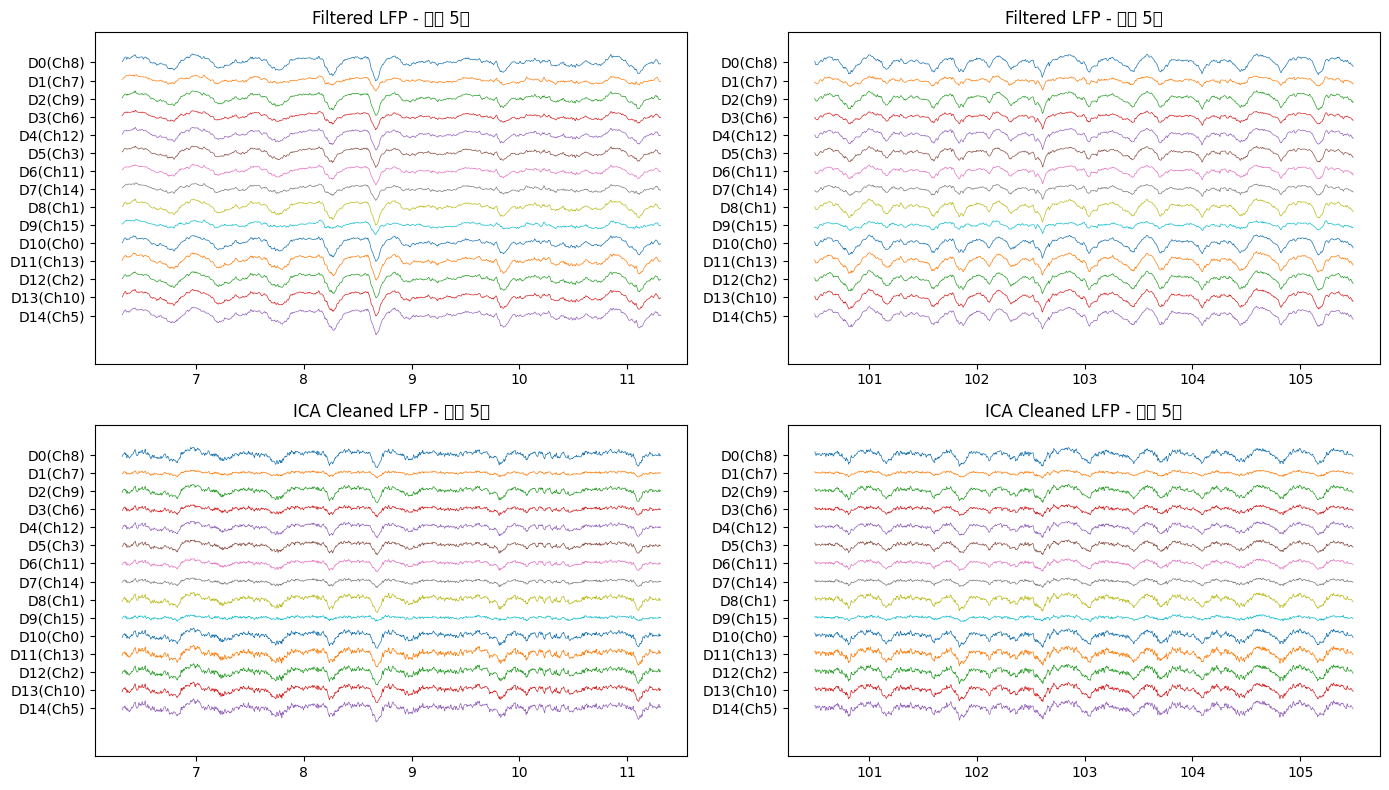

端部効果チェック: フィルタリングは全データ→Trimの順なので端部効果なし


In [13]:
# 端部効果の確認（最初と最後の数秒を比較）
check_sec = 5
check_samples = int(check_sec * fs)

fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# 最初
for idx in range(lfp_filtered.shape[1]):
    axes[0, 0].plot(lfp_times[:check_samples], lfp_filtered[:check_samples, idx] - idx*0.3, lw=0.5)
axes[0, 0].set_title(f'Filtered LFP - 最初 {check_sec}秒')
axes[0, 0].set_ylim(-5, 0.5)
axes[0, 0].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[0, 0].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

for idx in range(lfp_cleaned.shape[1]):
    axes[1, 0].plot(lfp_times[:check_samples], lfp_cleaned[:check_samples, idx] - idx*0.3, lw=0.5)
axes[1, 0].set_title(f'ICA Cleaned LFP - 最初 {check_sec}秒')
axes[1, 0].set_ylim(-5, 0.5)
axes[1, 0].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[1, 0].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

# 最後
for idx in range(lfp_filtered.shape[1]):
    axes[0, 1].plot(lfp_times[-check_samples:], lfp_filtered[-check_samples:, idx] - idx*0.3, lw=0.5)
axes[0, 1].set_title(f'Filtered LFP - 最後 {check_sec}秒')
axes[0, 1].set_ylim(-5, 0.5)
axes[0, 1].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[0, 1].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

for idx in range(lfp_cleaned.shape[1]):
    axes[1, 1].plot(lfp_times[-check_samples:], lfp_cleaned[-check_samples:, idx] - idx*0.3, lw=0.5)
axes[1, 1].set_title(f'ICA Cleaned LFP - 最後 {check_sec}秒')
axes[1, 1].set_ylim(-5, 0.5)
axes[1, 1].set_yticks([-idx*0.3 for idx in range(n_channels)])
axes[1, 1].set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_edge_check.png'), dpi=150)
plt.show()

print("端部効果チェック: フィルタリングは全データ→Trimの順なので端部効果なし")

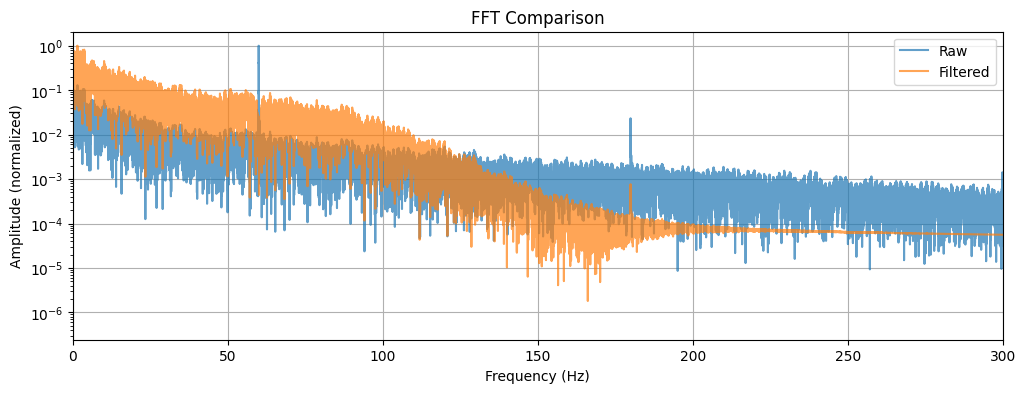

In [14]:
# FFTでフィルタ効果確認
from scipy.fft import fft, fftfreq

N = len(lfp_trimmed)
freqs_fft = fftfreq(N, 1/fs)[:N//2]

fft_raw = np.abs(fft(lfp_trimmed.mean(axis=1)))[:N//2]
fft_filt = np.abs(fft(lfp_filtered.mean(axis=1)))[:N//2]

fft_raw /= fft_raw.max()
fft_filt /= fft_filt.max()

plt.figure(figsize=(12, 4))
plt.semilogy(freqs_fft, fft_raw, alpha=0.7, label='Raw')
plt.semilogy(freqs_fft, fft_filt, alpha=0.7, label='Filtered')
plt.xlim(0, 300)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (normalized)')
plt.title('FFT Comparison')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\3847844917.py:28: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\wakel\AppData\Local\Temp\ipykernel_27048\3847844917.py:28: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\wakel\anaconda3\envs\neoeeg\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 38500 (\N{CJK UNIFIED IDEOGRAPH-9664}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\wakel\anaconda3\envs\neoeeg\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21435 (\N{CJK UNIFIED IDEOGRAPH-53BB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


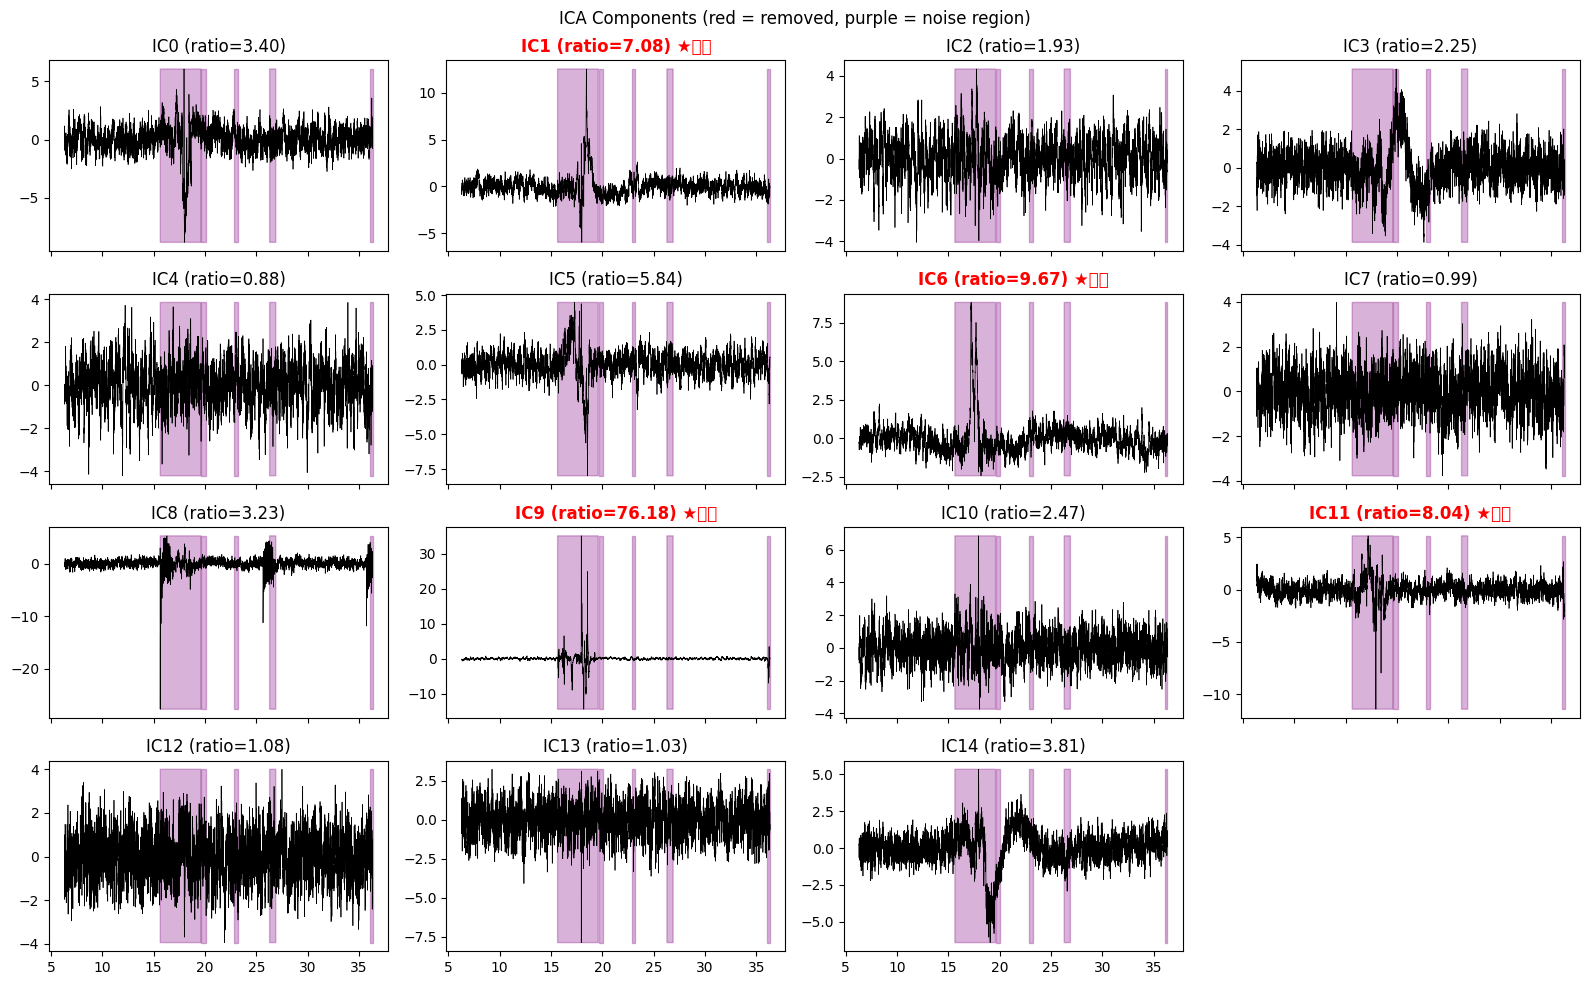

In [15]:
# ICA成分のプロット
def plot_ica_components(sources, noise_ratios, noise_mask, lfp_times, removed_ics, t_plot=30):
    """各ICA成分を表示"""
    n_components = sources.shape[1]
    n_cols = 4
    n_rows = (n_components + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 2.5 * n_rows), sharex=True)
    axes = axes.flatten()
    
    t_mask = lfp_times < lfp_times[0] + t_plot
    
    for i in range(n_components):
        ax = axes[i]
        ax.plot(lfp_times[t_mask], sources[t_mask, i], 'k-', lw=0.5)
        ax.fill_between(lfp_times[t_mask], sources[t_mask, i].min(), sources[t_mask, i].max(),
                        where=noise_mask[t_mask], alpha=0.3, color='purple')
        
        is_removed = i in removed_ics
        color = 'red' if is_removed else 'black'
        title = f'IC{i} (ratio={noise_ratios[i]:.2f})' + (' ★除去' if is_removed else '')
        ax.set_title(title, color=color, fontweight='bold' if is_removed else 'normal')
    
    for i in range(n_components, len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('ICA Components (red = removed, purple = noise region)', fontsize=12)
    plt.tight_layout()
    # plt.savefig('ica_components.png', dpi=150)
    plt.show()

# プロット実行
plot_ica_components(ica_sources, noise_ratios, noise_mask, lfp_times, removed_ics)


---
## 4. データ解析

In [16]:
# 刺激イベント取得
def get_stim_events(events, session_name="EVT02", stim_name="EVT01"):
    """刺激イベントを取得"""
    session_times, stim_times = None, None
    
    print("=== イベント一覧 ===")
    for evt in events:
        n = len(evt.times)
        if n > 0:
            print(f"  {evt.name}: {n}個")
            if evt.name == session_name:
                session_times = np.array(evt.times)
            if evt.name == stim_name:
                stim_times = np.array(evt.times)
    
    return session_times, stim_times

session_times, stim_times = get_stim_events(seg.events)

# セッション範囲定義 (9セッション x 10刺激)
n_sessions, n_stim_per_session = 9, 10
stim_sessions = stim_times.reshape(n_sessions, n_stim_per_session)
session_ranges = [(s[0], s[-1]) for s in stim_sessions]

print(f"\nセッション数: {n_sessions}, 各{n_stim_per_session}刺激")
for i, (start, end) in enumerate(session_ranges):
    print(f"  Session {i+1}: {start:.2f}s ~ {end:.2f}s")

=== イベント一覧 ===
  EVT01: 90個
  EVT02: 9個
  EVT03: 1242個
  Start: 1個
  Stop: 1個

セッション数: 9, 各10刺激
  Session 1: 15.68s ~ 16.58s
  Session 2: 25.68s ~ 26.58s
  Session 3: 35.76s ~ 36.66s
  Session 4: 45.84s ~ 46.74s
  Session 5: 55.84s ~ 56.74s
  Session 6: 65.92s ~ 66.82s
  Session 7: 76.00s ~ 76.90s
  Session 8: 86.00s ~ 86.90s
  Session 9: 96.07s ~ 96.97s


In [17]:
# パワースペクトル比較
BANDS = {
    'delta': (1, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 80)
}

def compute_psd(data, mask, fs, nperseg=1024):
    freqs, psd = signal.welch(data[mask], fs=fs, nperseg=nperseg, axis=0)
    return freqs, np.mean(psd, axis=1), np.std(psd, axis=1) / np.sqrt(psd.shape[1])

def compute_band_power(psd, freqs, band):
    mask = (freqs >= band[0]) & (freqs < band[1])
    return np.mean(psd[mask])

# # PSD計算
# freqs, psd_stim, psd_stim_sem = compute_psd(lfp_cleaned, clean_stim, fs)
# freqs, psd_nostim, psd_nostim_sem = compute_psd(lfp_cleaned, clean_nostim, fs)

# # バンドパワー計算
# print("\n=== バンドパワー比較 ===")
# print(f"{'Band':<10} {'NoStim':>12} {'Stim':>12} {'Change':>12}")
# print("-" * 48)

# band_results = {}
# for name, (low, high) in BANDS.items():
#     p_nostim = compute_band_power(psd_nostim, freqs, (low, high))
#     p_stim = compute_band_power(psd_stim, freqs, (low, high))
#     change = (p_stim - p_nostim) / p_nostim * 100
#     band_results[name] = {'nostim': p_nostim, 'stim': p_stim, 'change': change}
#     print(f"{name:<10} {p_nostim:>12.6f} {p_stim:>12.6f} {change:>+11.1f}%")

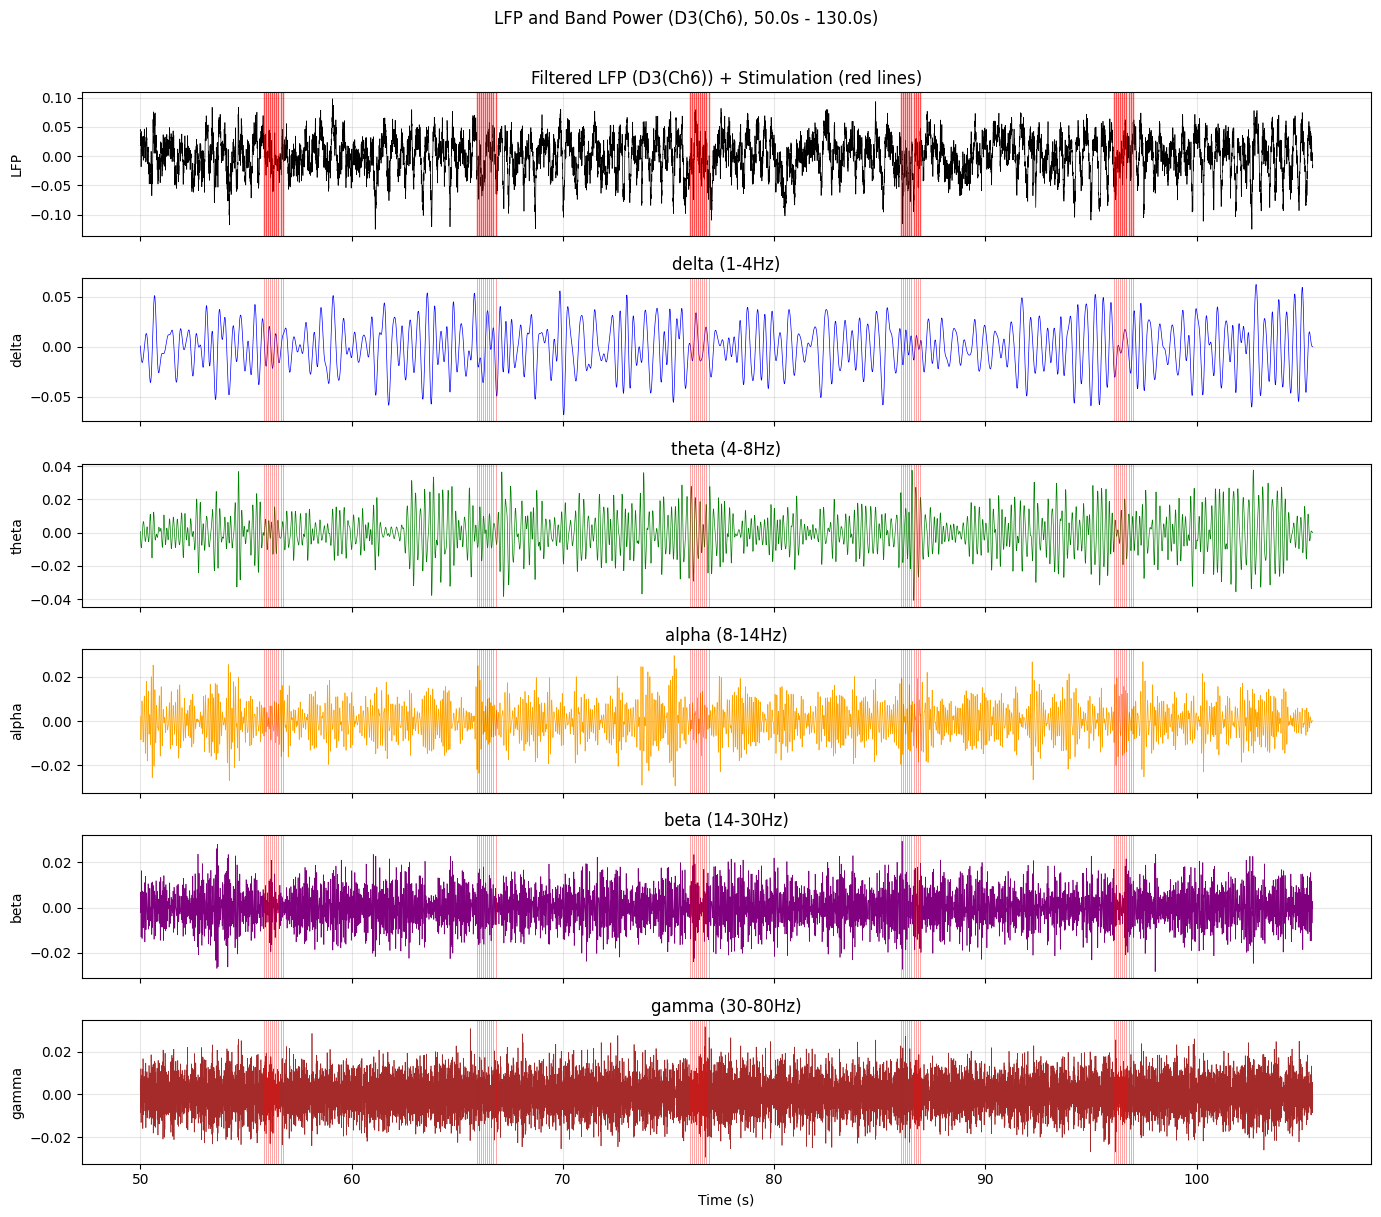

In [18]:
# フィルター後LFP + 刺激 + 帯域パワーのプロット
def plot_lfp_stim_bands(lfp_data, lfp_times, stim_times, fs,
                        original_ch_numbers=None,
                        t_start=None, t_duration=10, channel=0):
    """
    フィルター後LFP、刺激タイミング、各帯域パワーを重ねてプロット
    
    Parameters:
    -----------
    lfp_data : array (samples, channels)
    lfp_times : array
    stim_times : array
    fs : int
    original_ch_numbers : list (元のチャンネル番号)
    t_start : float (None の場合は最初から)
    t_duration : float (表示する秒数)
    channel : int (表示するチャンネル、深さインデックス)
    """
    if t_start is None:
        t_start = lfp_times[0]
    
    n_channels = lfp_data.shape[1]
    if original_ch_numbers is None:
        original_ch_numbers = list(range(n_channels))
    
    t_end = t_start + t_duration
    t_mask = (lfp_times >= t_start) & (lfp_times <= t_end)
    
    times_plot = lfp_times[t_mask]
    lfp_plot = lfp_data[t_mask, channel]
    
    # チャンネルラベル
    ch_label = f'D{channel}(Ch{original_ch_numbers[channel]})'
    
    # 各帯域を抽出
    bands = {
        'delta (1-4Hz)': (1, 4),
        'theta (4-8Hz)': (4, 8),
        'alpha (8-14Hz)': (8, 14),
        'beta (14-30Hz)': (14, 30),
        'gamma (30-80Hz)': (30, 80)
    }
    
    band_signals = {}
    for name, (low, high) in bands.items():
        filtered = bandpass_notch_filter(lfp_data[t_mask, channel:channel+1], low, high, fs)
        band_signals[name] = filtered.flatten()
    
    # 刺激タイミング（表示範囲内）
    stim_in_range = stim_times[(stim_times >= t_start) & (stim_times <= t_end)]
    
    # プロット
    fig, axes = plt.subplots(6, 1, figsize=(14, 12), sharex=True)
    
    # 1. フィルター後LFP + 刺激
    axes[0].plot(times_plot, lfp_plot, 'k-', lw=0.5)
    for stim_t in stim_in_range:
        axes[0].axvline(stim_t, color='red', alpha=0.7, lw=1)
    axes[0].set_ylabel('LFP')
    axes[0].set_title(f'Filtered LFP ({ch_label}) + Stimulation (red lines)')
    axes[0].grid(True, alpha=0.3)
    
    # 2-6. 各帯域
    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    for idx, (name, sig) in enumerate(band_signals.items()):
        ax = axes[idx + 1]
        ax.plot(times_plot, sig, color=colors[idx], lw=0.5)
        for stim_t in stim_in_range:
            ax.axvline(stim_t, color='red', alpha=0.5, lw=0.5)
        ax.set_ylabel(name.split()[0])
        ax.set_title(name)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time (s)')
    
    plt.suptitle(f'LFP and Band Power ({ch_label}, {t_start:.1f}s - {t_end:.1f}s)', fontsize=12, y=1.01)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_lfp_stim_bands.png'), dpi=150)
    plt.show()


# 実行例
plot_lfp_stim_bands(
    lfp_cleaned,
    lfp_times, 
    stim_times, 
    fs,
    original_ch_numbers=original_ch_numbers,
    t_start=50,
    t_duration=80,
    channel=3
)

---
## オプション: ウェーブレット解析 & 位相解析

In [19]:
# ウェーブレット解析（必要な場合のみ実行）
def wavelet_analysis(data, fs, frequencies=np.arange(1, 61), wavelet="cmor1.5-1.0"):
    """ウェーブレット変換"""
    scales = pywt.frequency2scale(wavelet, frequencies) * fs
    cwt, _ = pywt.cwt(data.T, scales, wavelet, sampling_period=1/fs)
    return np.abs(cwt), frequencies

# 実行例（時間がかかるため必要時のみ）
# cwt_result, cwt_freqs = wavelet_analysis(lfp_cleaned, fs)

In [20]:
# ウェーブレット結果のプロット
def plot_wavelet(cwt_result, cwt_freqs, lfp_times, stim_times=None, 
                 original_ch_numbers=None,
                 channel=0, t_start=None, t_duration=30):
    """
    ウェーブレットスペクトログラムをプロット
    
    Parameters:
    -----------
    cwt_result : array (freqs, channels, samples)
    cwt_freqs : array
    lfp_times : array
    stim_times : array (optional)
    original_ch_numbers : list (元のチャンネル番号)
    channel : int (深さインデックス)
    t_start : float
    t_duration : float
    """
    n_channels = cwt_result.shape[1]
    if original_ch_numbers is None:
        original_ch_numbers = list(range(n_channels))
    
    if t_start is None:
        t_start = lfp_times[0]
    
    t_end = t_start + t_duration
    t_mask = (lfp_times >= t_start) & (lfp_times <= t_end)
    idx_start = np.where(t_mask)[0][0]
    idx_end = np.where(t_mask)[0][-1]
    
    times_plot = lfp_times[t_mask]
    cwt_plot = cwt_result[:, channel, idx_start:idx_end+1]
    
    ch_label = f'D{channel}(Ch{original_ch_numbers[channel]})'
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    im = ax.imshow(cwt_plot, aspect='auto', origin='lower', cmap='jet',
                   extent=[times_plot[0], times_plot[-1], cwt_freqs[0], cwt_freqs[-1]],
                   vmin=0, vmax=np.percentile(cwt_plot, 95))
    
    if stim_times is not None:
        stim_in_range = stim_times[(stim_times >= t_start) & (stim_times <= t_end)]
        for stim_t in stim_in_range:
            ax.axvline(stim_t, color='white', alpha=0.7, lw=1, ls='--')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Frequency (Hz)')
    ax.set_title(f'Wavelet Spectrogram ({ch_label})')
    plt.colorbar(im, ax=ax, label='Power')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_wavelet_ch{channel}.png'), dpi=150)
    plt.show()


# 単一チャンネルをプロット
# plot_wavelet(cwt_result, cwt_freqs, lfp_times, stim_times, 
#              original_ch_numbers=original_ch_numbers,
#              channel=0, t_duration=30)


# 全チャンネルをタイル表示
def plot_wavelet_all_channels(cwt_result, cwt_freqs, lfp_times,
                               original_ch_numbers=None,
                               t_start=None, t_duration=30):
    """全チャンネルのスペクトログラムをタイル表示"""
    n_channels = cwt_result.shape[1]
    n_cols = 4
    n_rows = (n_channels + n_cols - 1) // n_cols
    
    if original_ch_numbers is None:
        original_ch_numbers = list(range(n_channels))
    
    if t_start is None:
        t_start = lfp_times[0]
    
    t_end = t_start + t_duration
    t_mask = (lfp_times >= t_start) & (lfp_times <= t_end)
    idx_start = np.where(t_mask)[0][0]
    idx_end = np.where(t_mask)[0][-1]
    
    times_plot = lfp_times[t_mask]
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 3 * n_rows))
    axes = axes.flatten()
    
    for ch_idx in range(n_channels):
        ax = axes[ch_idx]
        cwt_plot = cwt_result[:, ch_idx, idx_start:idx_end+1]
        
        ch_label = f'D{ch_idx}(Ch{original_ch_numbers[ch_idx]})'
        
        im = ax.imshow(cwt_plot, aspect='auto', origin='lower', cmap='jet',
                       extent=[times_plot[0], times_plot[-1], cwt_freqs[0], cwt_freqs[-1]],
                       vmin=0, vmax=np.percentile(cwt_plot, 95))
        ax.set_title(ch_label)
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Freq (Hz)')
    
    for idx in range(n_channels, len(axes)):
        axes[idx].set_visible(False)
    
    plt.suptitle('Wavelet Spectrogram - All Channels', fontsize=12)
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_wavelet_all.png'), dpi=150)
    plt.show()


# 実行
# plot_wavelet_all_channels(cwt_result, cwt_freqs, lfp_times,
#                            original_ch_numbers=original_ch_numbers,
#                            t_duration=100)

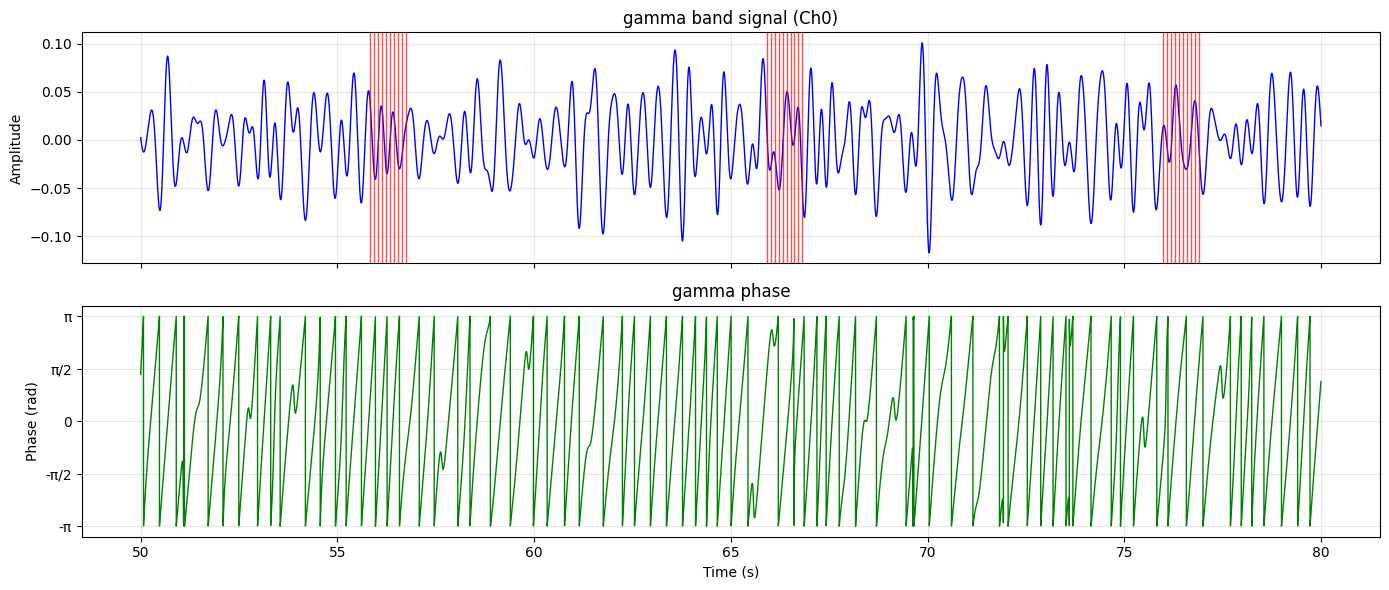

In [21]:
# 位相解析（必要な場合のみ実行）
def compute_phase(data, fs, band=(1, 4)):
    """特定バンドの位相を計算"""
    filtered = bandpass_notch_filter(data, band[0], band[1], fs).T
    phases = np.zeros_like(filtered)
    for ch in range(len(filtered)):
        analytic = signal.hilbert(filtered[ch])
        phases[ch] = np.angle(analytic)
    return filtered, phases

# 実行例
delta_signal, delta_phase = compute_phase(lfp_cleaned, fs, band=(1, 4))
# 位相解析の可視化と位相同期解析

# 1. 信号と位相のプロット
def plot_signal_phase(band_signal, band_phase, lfp_times, stim_times=None,
                      channel=0, t_start=00, t_duration=10, band_name="delta"):
    """帯域信号と位相をプロット"""
    if t_start is None:
        t_start = lfp_times[0]
    
    t_end = t_start + t_duration
    t_mask = (lfp_times >= t_start) & (lfp_times <= t_end)
    
    times_plot = lfp_times[t_mask]
    sig_plot = band_signal[channel, t_mask]
    phase_plot = band_phase[channel, t_mask]
    
    fig, axes = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
    
    # 信号
    axes[0].plot(times_plot, sig_plot, 'b-', lw=1)
    if stim_times is not None:
        stim_in_range = stim_times[(stim_times >= t_start) & (stim_times <= t_end)]
        for stim_t in stim_in_range:
            axes[0].axvline(stim_t, color='red', alpha=0.7, lw=1)
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'{band_name} band signal (Ch{channel})')
    axes[0].grid(True, alpha=0.3)
    
    # 位相
    axes[1].plot(times_plot, phase_plot, 'g-', lw=1)
    axes[1].set_ylabel('Phase (rad)')
    axes[1].set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    axes[1].set_yticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    axes[1].set_xlabel('Time (s)')
    axes[1].set_title(f'{band_name} phase')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    # plt.savefig(f'{band_name}_signal_phase.png', dpi=150)
    plt.show()

# 実行
plot_signal_phase(delta_signal, delta_phase, lfp_times, stim_times, 
                  channel=0, t_start=50, t_duration=30, band_name="gamma")


In [22]:
# これを実行して結果を貼ってもらえますか？
from scipy.signal import welch

freqs, psd = welch(lfp_cleaned[:, 0], fs=fs, nperseg=4096)

# 各帯域のパワー
bands = {'Delta(1-4)': (1,4), 'Theta(4-8)': (4,8), 'Beta(14-30)': (14,30), 'Gamma(30-80)': (30,80)}
for name, (lo, hi) in bands.items():
    mask = (freqs >= lo) & (freqs <= hi)
    print(f"{name}: {np.sum(psd[mask]):.2e}")

Delta(1-4): 6.38e-03
Theta(4-8): 1.58e-03
Beta(14-30): 5.24e-04
Gamma(30-80): 4.65e-04


margin_before=2.0  → 刺激前2秒
margin_after=3.0   → 刺激後3秒

In [23]:
def create_session_mask(lfp_times, session_ranges, margin_before=1.0, margin_after=2.0):
    """
    セッション全体 + 前後のマージンでマスク作成
    
    margin_before: セッション開始前（ベースライン）
    margin_after: セッション終了後（回復期間も含める）
    """
    stim_mask = np.zeros(len(lfp_times), dtype=bool)
    baseline_mask = np.zeros(len(lfp_times), dtype=bool)
    post_mask = np.zeros(len(lfp_times), dtype=bool)
    
    for start, end in session_ranges:
        # 刺激中
        stim_mask |= (lfp_times >= start) & (lfp_times <= end)
        # 刺激前（ベースライン）
        baseline_mask |= (lfp_times >= start - margin_before) & (lfp_times < start)
        # 刺激後（回復）
        post_mask |= (lfp_times > end) & (lfp_times <= end + margin_after)
    
    return stim_mask, baseline_mask, post_mask


stim_mask, baseline_mask, post_mask = create_session_mask(
    lfp_times, session_ranges, margin_before=2.0, margin_after=3.0
)

# ノイズ除外
clean_stim = stim_mask & ~noise_mask
clean_baseline = baseline_mask & ~noise_mask
clean_post = post_mask & ~noise_mask

print(f"刺激中: {100*np.sum(clean_stim)/len(lfp_times):.1f}%")
print(f"刺激前: {100*np.sum(clean_baseline)/len(lfp_times):.1f}%")
print(f"刺激後: {100*np.sum(clean_post)/len(lfp_times):.1f}%")



# === PSD計算前の確認 ===
print("=== マスク確認 ===")
print(f"clean_baseline sum: {np.sum(clean_baseline)}")
print(f"clean_stim sum: {np.sum(clean_stim)}")
print(f"clean_post sum: {np.sum(clean_post)}")

# 実際にPSDに使われるデータ
print(f"\nlfp_cleaned[clean_baseline] mean: {np.mean(lfp_cleaned[clean_baseline]):.6f}")
print(f"lfp_cleaned[clean_stim] mean: {np.mean(lfp_cleaned[clean_stim]):.6f}")
print(f"lfp_cleaned[clean_post] mean: {np.mean(lfp_cleaned[clean_post]):.6f}")

刺激中: 3.0%
刺激前: 15.2%
刺激後: 14.5%
=== マスク確認 ===
clean_baseline sum: 15080
clean_stim sum: 2977
clean_post sum: 14421

lfp_cleaned[clean_baseline] mean: -0.000164
lfp_cleaned[clean_stim] mean: -0.007294
lfp_cleaned[clean_post] mean: -0.001060


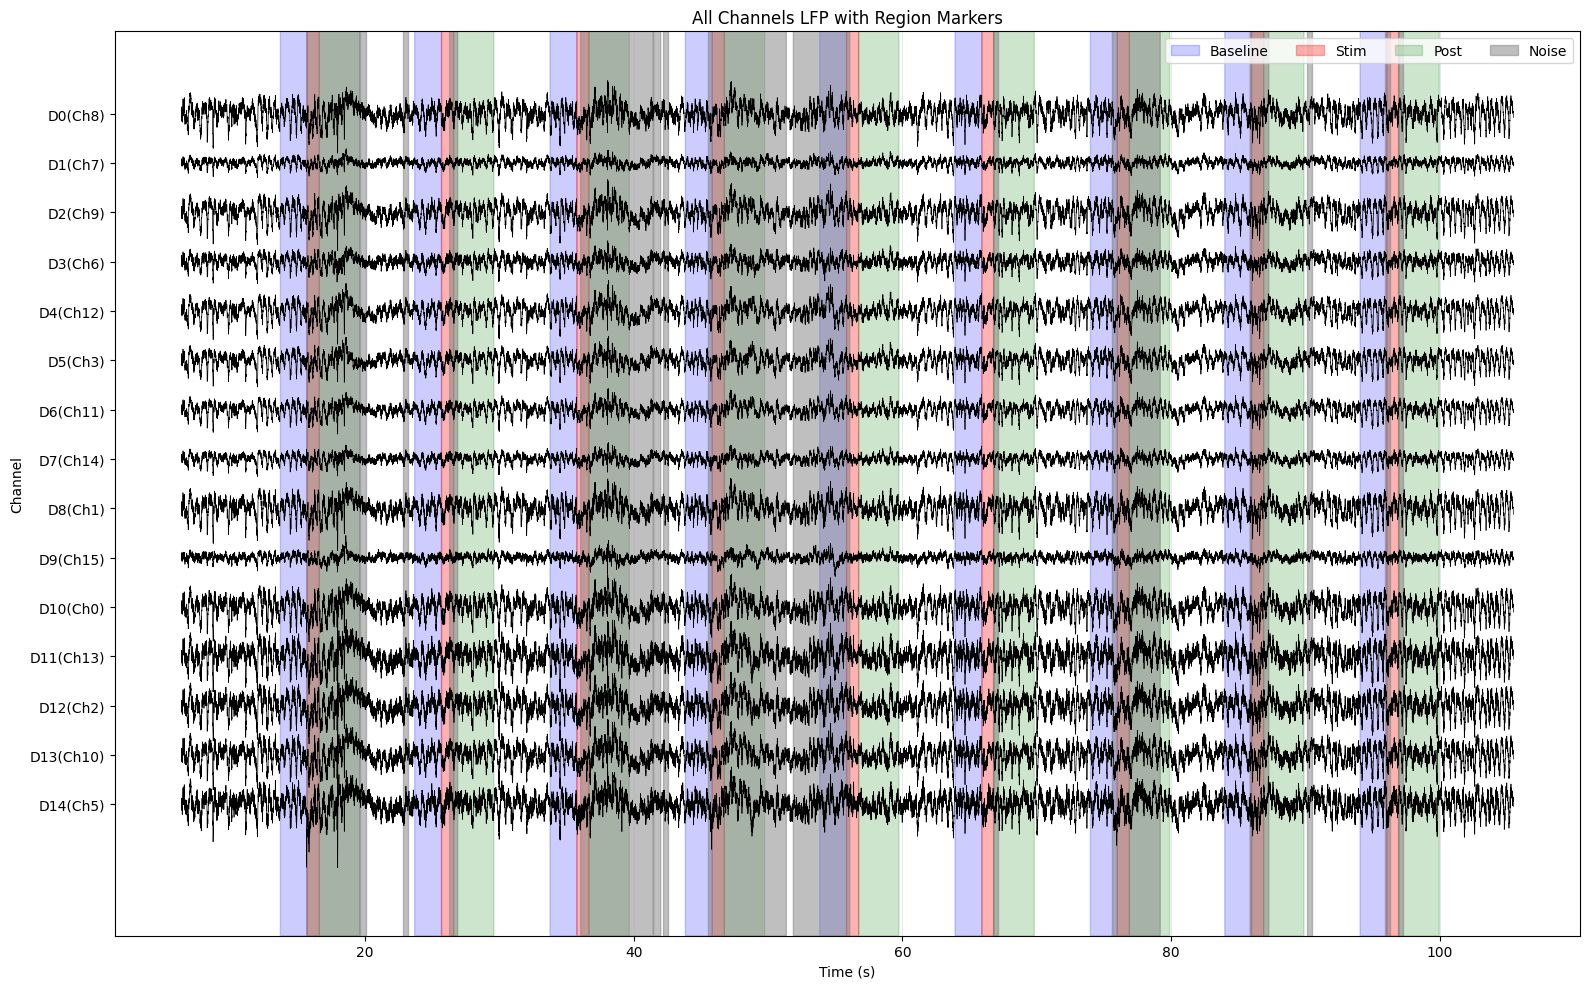

In [24]:
# 刺激・刺激前後・ノイズの区分を色分けしたLFPプロット
def plot_all_channels_with_regions(lfp_data, lfp_times, 
                                    stim_mask, baseline_mask, post_mask, noise_mask,
                                    original_ch_numbers=None,
                                    t_start=None, t_duration=60):
    """全チャンネルLFPをマスク領域とともにプロット"""
    
    if t_start is None:
        t_start = lfp_times[0]
    
    t_end = t_start + t_duration
    t_mask = (lfp_times >= t_start) & (lfp_times <= t_end)
    
    times = lfp_times[t_mask]
    n_channels = lfp_data.shape[1]
    
    # original_ch_numbersが指定されていない場合は0,1,2...を使う
    if original_ch_numbers is None:
        original_ch_numbers = list(range(n_channels))
    
    stim_plot = stim_mask[t_mask]
    base_plot = baseline_mask[t_mask]
    post_plot = post_mask[t_mask]
    noise_plot = noise_mask[t_mask]
    
    fig, ax = plt.subplots(figsize=(16, 10))
    
    # 背景色
    spacing = 0.3
    ymin = -n_channels * spacing - 0.5
    ymax = 0.5
    
    ax.fill_between(times, ymin, ymax, where=base_plot, color='blue', alpha=0.2, label='Baseline')
    ax.fill_between(times, ymin, ymax, where=stim_plot, color='red', alpha=0.3, label='Stim')
    ax.fill_between(times, ymin, ymax, where=post_plot, color='green', alpha=0.2, label='Post')
    ax.fill_between(times, ymin, ymax, where=noise_plot, color='gray', alpha=0.5, label='Noise')
    
    # LFP波形（全チャンネル）
    for idx in range(n_channels):
        ax.plot(times, lfp_data[t_mask, idx] - idx * spacing, 'k-', lw=0.5)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Channel')
    ax.set_ylim(ymin, ymax)
    ax.set_yticks([-idx * spacing for idx in range(n_channels)])
    ax.set_yticklabels([f'D{idx}(Ch{original_ch_numbers[idx]})' for idx in range(n_channels)])
    ax.set_title('All Channels LFP with Region Markers')
    ax.legend(loc='upper right', ncol=4)
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_lfp_all_channels_regions.png'), dpi=150)
    plt.show()


# 実行
plot_all_channels_with_regions(
    lfp_cleaned, lfp_times,
    stim_mask, baseline_mask, post_mask, noise_mask,
    original_ch_numbers=original_ch_numbers,
    t_start=None,
    t_duration=110
)

=== 3条件バンドパワー比較 ===
Band           Baseline         Stim         Post     Stim変化     Post変化
----------------------------------------------------------------------
delta          0.000426     0.000189     0.000288     -55.6%     -32.4%
theta          0.000065     0.000064     0.000041      -1.8%     -37.7%
alpha          0.000017     0.000029     0.000014     +65.6%     -19.2%
beta           0.000006     0.000009     0.000006     +51.2%      -4.5%
gamma          0.000002     0.000002     0.000002      +8.3%     -11.4%


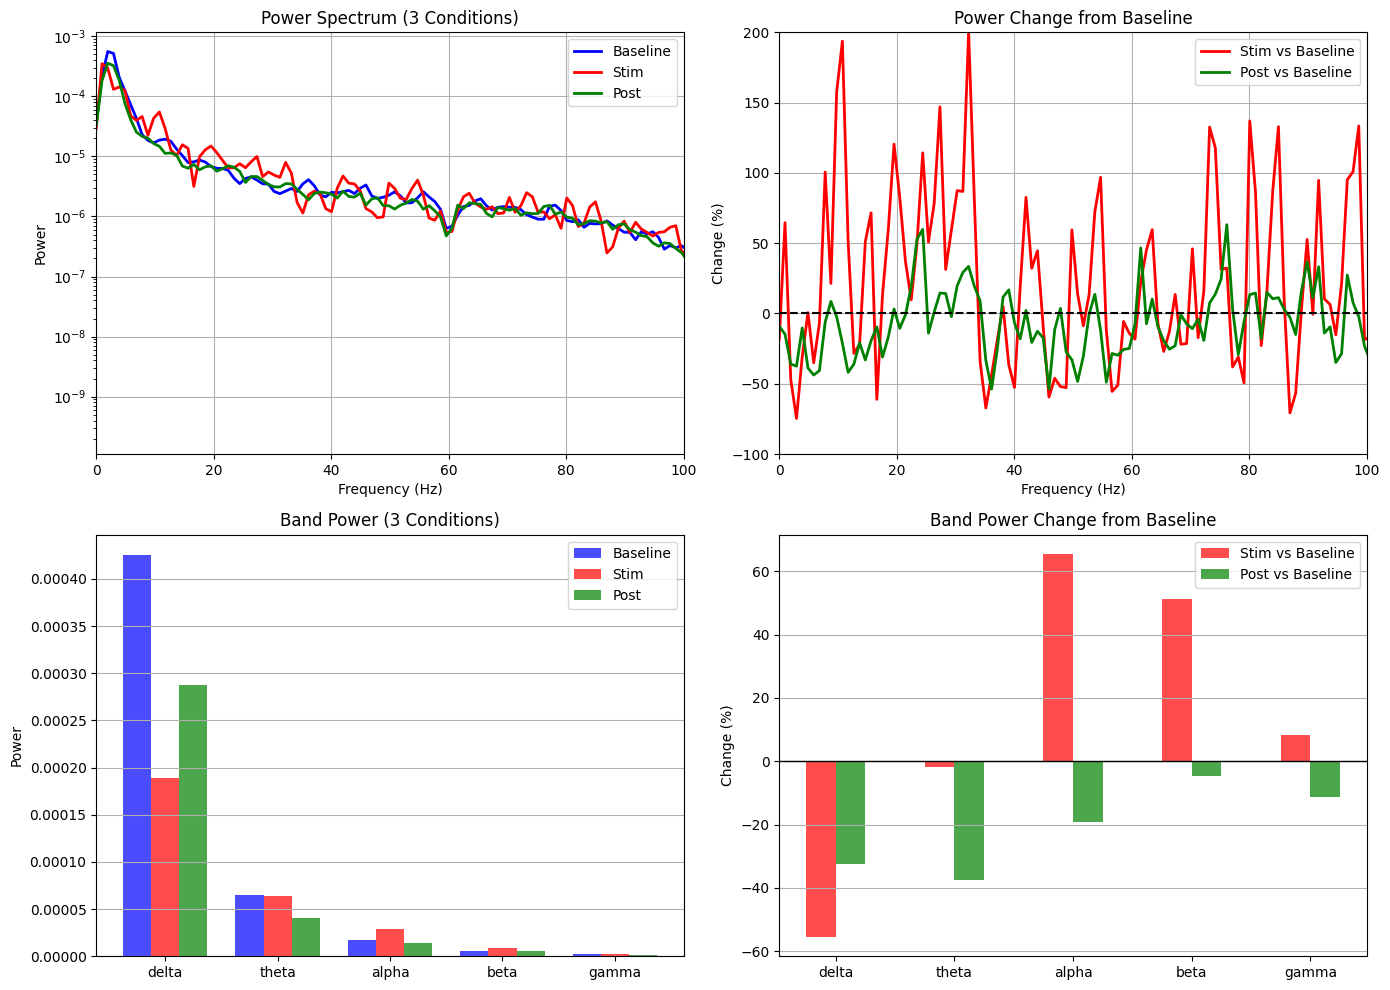

In [25]:
# 3条件のPSD計算
freqs, psd_baseline, _ = compute_psd(lfp_cleaned, clean_baseline, fs)
freqs, psd_stim, _ = compute_psd(lfp_cleaned, clean_stim, fs)
freqs, psd_post, _ = compute_psd(lfp_cleaned, clean_post, fs)

# バンドパワー計算 & 表示
print("=== 3条件バンドパワー比較 ===")
print(f"{'Band':<10} {'Baseline':>12} {'Stim':>12} {'Post':>12} {'Stim変化':>10} {'Post変化':>10}")
print("-" * 70)

bands = list(BANDS.keys())
baseline_power = []
stim_power = []
post_power = []
change_stim_list = []
change_post_list = []

for name, (low, high) in BANDS.items():
    p_base = compute_band_power(psd_baseline, freqs, (low, high))
    p_stim = compute_band_power(psd_stim, freqs, (low, high))
    p_post = compute_band_power(psd_post, freqs, (low, high))
    
    change_stim = (p_stim - p_base) / p_base * 100
    change_post = (p_post - p_base) / p_base * 100
    
    baseline_power.append(p_base)
    stim_power.append(p_stim)
    post_power.append(p_post)
    change_stim_list.append(change_stim)
    change_post_list.append(change_post)
    
    print(f"{name:<10} {p_base:>12.6f} {p_stim:>12.6f} {p_post:>12.6f} {change_stim:>+9.1f}% {change_post:>+9.1f}%")

# プロット
x = np.arange(len(bands))
width = 0.25

# 最終プロット（3条件版）
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 左上: パワースペクトル（3条件）
axes[0, 0].semilogy(freqs, psd_baseline, 'b-', lw=2, label='Baseline')
axes[0, 0].semilogy(freqs, psd_stim, 'r-', lw=2, label='Stim')
axes[0, 0].semilogy(freqs, psd_post, 'g-', lw=2, label='Post')
axes[0, 0].set_xlabel('Frequency (Hz)')
axes[0, 0].set_ylabel('Power')
axes[0, 0].set_title('Power Spectrum (3 Conditions)')
axes[0, 0].set_xlim(0, 100)
axes[0, 0].legend()
axes[0, 0].grid(True)

# 右上: パワー変化率
change_from_baseline = (psd_stim - psd_baseline) / psd_baseline * 100
axes[0, 1].plot(freqs, change_from_baseline, 'r-', lw=2, label='Stim vs Baseline')
change_post_baseline = (psd_post - psd_baseline) / psd_baseline * 100
axes[0, 1].plot(freqs, change_post_baseline, 'g-', lw=2, label='Post vs Baseline')
axes[0, 1].axhline(0, color='k', ls='--')
axes[0, 1].set_xlabel('Frequency (Hz)')
axes[0, 1].set_ylabel('Change (%)')
axes[0, 1].set_title('Power Change from Baseline')
axes[0, 1].set_xlim(0, 100)
axes[0, 1].set_ylim(-100, 200)  # 見やすい範囲に
axes[0, 1].legend()
axes[0, 1].grid(True)

# 左下: バンドパワー棒グラフ（3条件）
x = np.arange(len(bands))
width = 0.25
axes[1, 0].bar(x - width, baseline_power, width, label='Baseline', color='blue', alpha=0.7)
axes[1, 0].bar(x, stim_power, width, label='Stim', color='red', alpha=0.7)
axes[1, 0].bar(x + width, post_power, width, label='Post', color='green', alpha=0.7)
axes[1, 0].set_ylabel('Power')
axes[1, 0].set_title('Band Power (3 Conditions)')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(bands)
axes[1, 0].legend()
axes[1, 0].grid(True, axis='y')

# 右下: バンドパワー変化率
axes[1, 1].bar(x - width/2, change_stim_list, width, label='Stim vs Baseline', color='red', alpha=0.7)
axes[1, 1].bar(x + width/2, change_post_list, width, label='Post vs Baseline', color='green', alpha=0.7)
axes[1, 1].axhline(0, color='k', lw=1)
axes[1, 1].set_ylabel('Change (%)')
axes[1, 1].set_title('Band Power Change from Baseline')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(bands)
axes[1, 1].legend()
axes[1, 1].grid(True, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_power_analysis_3conditions.png'), dpi=150)
plt.show()

チャンネル別パワー計算完了: (15, 5, 3)


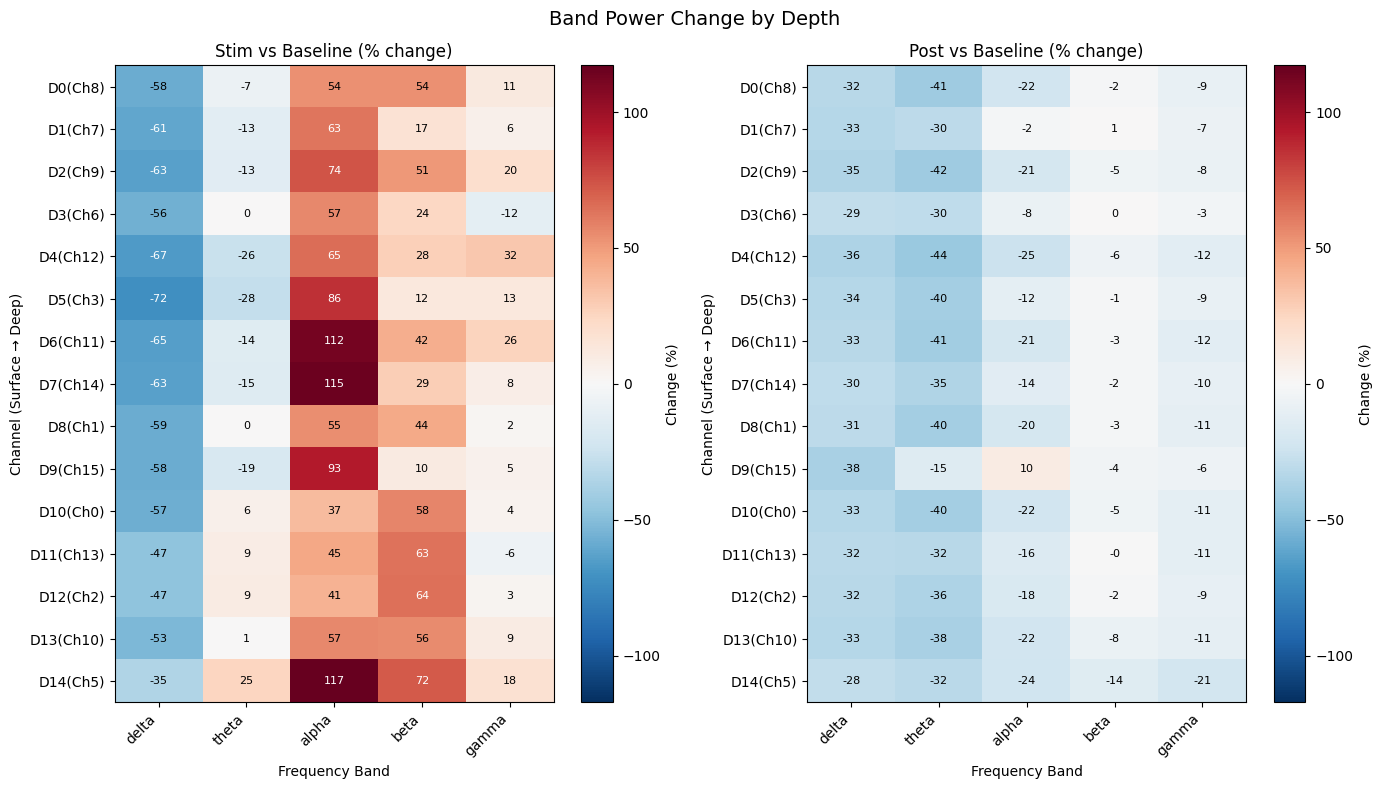

赤=増加, 青=減少


'"\n        Stim vs Baseline          Post vs Baseline\n        delta theta alpha beta gamma   delta theta alpha beta gamma\nD0(Ch8)  +15   +10   +5   -2   +8      +5    +3   +2   -1   +3\nD1(Ch7)  +18   +12   +6   +1   +10     +7    +4   +3   +0   +4\nD2(Ch9)  +35   +25   +15  +8   +20     +12   +8   +5   +2   +7   ← 刺激応答が強い層?\n...\nD14(Ch5) +10   +8    +3   -1   +5      +3    +2   +1   -1   +2\n\n🔴赤=増加  🔵青=減少\n'

In [26]:
# ============================================================
# チャンネル別バンドパワーを計算
# ============================================================
n_channels = lfp_cleaned.shape[1]
n_bands = len(BANDS)
n_conditions = 3  # baseline, stim, post

channel_band_power = np.zeros((n_channels, n_bands, n_conditions))

for ch in range(n_channels):
    freqs_ch, psd_base, _ = compute_psd(lfp_cleaned[:, ch:ch+1], clean_baseline, fs)
    _, psd_stim_ch, _ = compute_psd(lfp_cleaned[:, ch:ch+1], clean_stim, fs)
    _, psd_post_ch, _ = compute_psd(lfp_cleaned[:, ch:ch+1], clean_post, fs)
    
    for b, (band_name, (lo, hi)) in enumerate(BANDS.items()):
        channel_band_power[ch, b, 0] = compute_band_power(psd_base, freqs_ch, (lo, hi))
        channel_band_power[ch, b, 1] = compute_band_power(psd_stim_ch, freqs_ch, (lo, hi))
        channel_band_power[ch, b, 2] = compute_band_power(psd_post_ch, freqs_ch, (lo, hi))

print(f"チャンネル別パワー計算完了: {channel_band_power.shape}")

# ============================================================
# 変化率ヒートマップ
# ============================================================

# 変化率を計算
baseline_power_ch = channel_band_power[:, :, 0]  # (n_ch, n_bands)
stim_power_ch = channel_band_power[:, :, 1]
post_power_ch = channel_band_power[:, :, 2]

change_stim = (stim_power_ch - baseline_power_ch) / baseline_power_ch * 100
change_post = (post_power_ch - baseline_power_ch) / baseline_power_ch * 100

# プロット
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

band_names = list(BANDS.keys())
ch_labels = [f'D{i}(Ch{original_ch_numbers[i]})' for i in range(n_channels)]

# カラーマップの範囲を対称に
vmax = max(np.abs(change_stim).max(), np.abs(change_post).max())
vmin = -vmax

# Stim vs Baseline
im1 = axes[0].imshow(change_stim, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
axes[0].set_xticks(range(n_bands))
axes[0].set_xticklabels(band_names, rotation=45, ha='right')
axes[0].set_yticks(range(n_channels))
axes[0].set_yticklabels(ch_labels)
axes[0].set_xlabel('Frequency Band')
axes[0].set_ylabel('Channel (Surface → Deep)')
axes[0].set_title('Stim vs Baseline (% change)')
plt.colorbar(im1, ax=axes[0], label='Change (%)')

# 数値を表示
for i in range(n_channels):
    for j in range(n_bands):
        val = change_stim[i, j]
        color = 'white' if abs(val) > vmax * 0.5 else 'black'
        axes[0].text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=8, color=color)

# Post vs Baseline
im2 = axes[1].imshow(change_post, cmap='RdBu_r', aspect='auto', vmin=vmin, vmax=vmax)
axes[1].set_xticks(range(n_bands))
axes[1].set_xticklabels(band_names, rotation=45, ha='right')
axes[1].set_yticks(range(n_channels))
axes[1].set_yticklabels(ch_labels)
axes[1].set_xlabel('Frequency Band')
axes[1].set_ylabel('Channel (Surface → Deep)')
axes[1].set_title('Post vs Baseline (% change)')
plt.colorbar(im2, ax=axes[1], label='Change (%)')

# 数値を表示
for i in range(n_channels):
    for j in range(n_bands):
        val = change_post[i, j]
        color = 'white' if abs(val) > vmax * 0.5 else 'black'
        axes[1].text(j, i, f'{val:.0f}', ha='center', va='center', fontsize=8, color=color)

plt.suptitle('Band Power Change by Depth', fontsize=14)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, f'{BASENAME}_channel_power_heatmap.png'), dpi=150)
plt.show()

print("赤=増加, 青=減少")



## 出力イメージ
""""
        Stim vs Baseline          Post vs Baseline
        delta theta alpha beta gamma   delta theta alpha beta gamma
D0(Ch8)  +15   +10   +5   -2   +8      +5    +3   +2   -1   +3
D1(Ch7)  +18   +12   +6   +1   +10     +7    +4   +3   +0   +4
D2(Ch9)  +35   +25   +15  +8   +20     +12   +8   +5   +2   +7   ← 刺激応答が強い層?
...
D14(Ch5) +10   +8    +3   -1   +5      +3    +2   +1   -1   +2

🔴赤=増加  🔵青=減少
"""

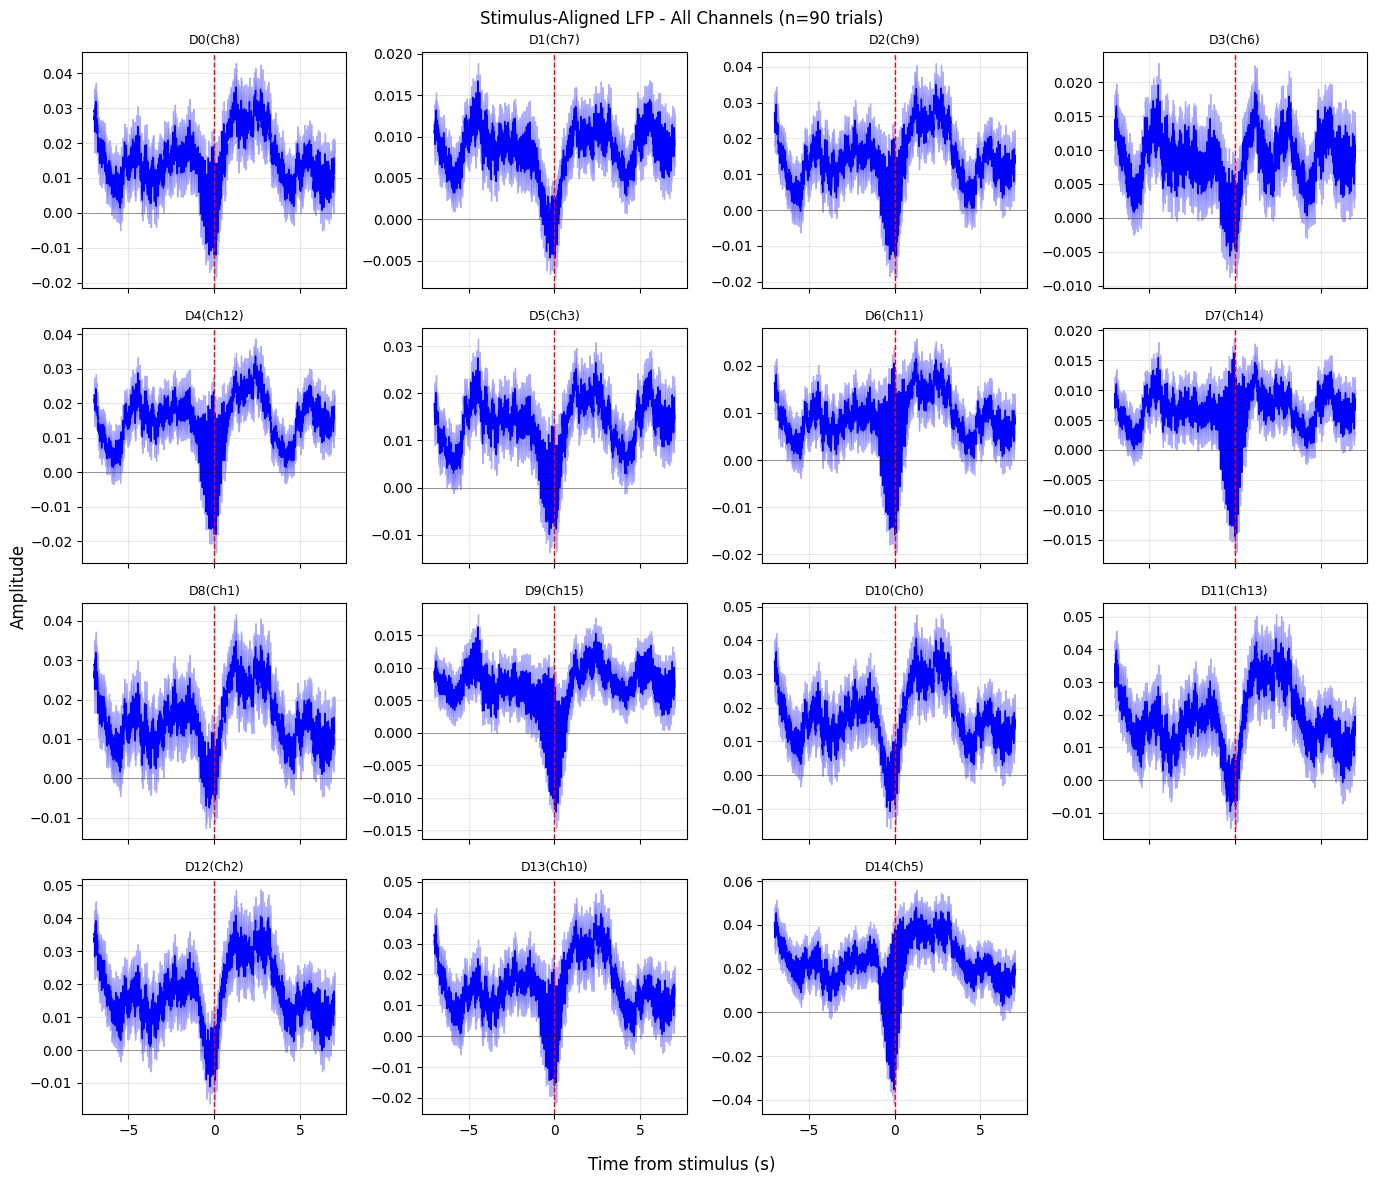

In [48]:
def plot_stim_aligned_all_channels(lfp_data, lfp_times, stim_times, fs,
                                    pre_sec=2.0, post_sec=3.0,
                                    baseline_sec=0.5,  # ← 追加
                                    original_ch_numbers=None,
                                    baseline_correct=True):
    """全チャンネルの刺激応答を並べて表示"""
    n_channels = lfp_data.shape[1]
    
    fig, axes = plt.subplots(4, 4, figsize=(14, 12), sharex=True)
    axes = axes.flatten()
    
    pre_samples = int(pre_sec * fs)
    post_samples = int(post_sec * fs)
    baseline_samples = int(baseline_sec * fs)
    time_axis = np.linspace(-pre_sec, post_sec, pre_samples + post_samples)
    
    for ch in range(min(n_channels, 16)):
        ax = axes[ch]
        
        epochs = []
        for stim_t in stim_times:
            idx = np.searchsorted(lfp_times, stim_t)
            start = idx - pre_samples
            end = idx + post_samples
            if start >= 0 and end < len(lfp_data):
                epoch = lfp_data[start:end, ch].copy()
                
                # ベースライン補正（刺激直前のbaseline_sec秒だけ）
                if baseline_correct:
                    baseline = np.mean(epoch[pre_samples - baseline_samples:pre_samples])
                    epoch = epoch - baseline
                
                epochs.append(epoch)
        
        epochs = np.array(epochs)
        mean_epoch = np.mean(epochs, axis=0)
        sem_epoch = np.std(epochs, axis=0) / np.sqrt(len(epochs))
        
        ax.fill_between(time_axis, mean_epoch - sem_epoch, mean_epoch + sem_epoch,
                        color='blue', alpha=0.3)
        ax.plot(time_axis, mean_epoch, 'b-', lw=1)
        ax.axvline(0, color='red', ls='--', lw=1)
        ax.axhline(0, color='k', ls='-', lw=0.5, alpha=0.5)
        
        ch_label = f'D{ch}(Ch{original_ch_numbers[ch]})' if original_ch_numbers else f'Ch{ch}'
        ax.set_title(ch_label, fontsize=9)
        ax.grid(True, alpha=0.3)
    
    for i in range(n_channels, 16):
        axes[i].set_visible(False)
    
    fig.supxlabel('Time from stimulus (s)')
    fig.supylabel('Amplitude')
    plt.suptitle(f'Stimulus-Aligned LFP - All Channels (n={len(epochs)} trials)', fontsize=12)
    plt.tight_layout()
    plt.show()


# 実行
plot_stim_aligned_all_channels(
    lfp_cleaned, lfp_times, stim_times, fs,
    pre_sec=7.0, post_sec=7.0,
    baseline_sec=0.5,  # 刺激直前0.5秒でベースライン補正
    original_ch_numbers=original_ch_numbers,
    baseline_correct=True
)

In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider
plt.rcParams['font.family'] = 'MS Gothic'  # または 'Yu Gothic', 'Meiryo'

def plot_stim_zoom(stim_idx=0, window_ms=200, y_scale=1.0):
    """刺激前後を拡大表示"""
    stim_time = stim_times[stim_idx]
    window_sec = window_ms / 1000
    
    t_start = stim_time - window_sec/2
    t_end = stim_time + window_sec/2
    mask = (lfp_times >= t_start) & (lfp_times <= t_end)
    
    plt.figure(figsize=(12, 4))
    plt.plot(lfp_times[mask] - stim_time, lfp_cleaned[mask, 7] * y_scale)
    plt.axvline(0, color='r', linewidth=2, label='刺激')
    plt.xlabel('刺激からの時間 (s)')
    plt.ylabel('LFP')
    plt.title(f'刺激 #{stim_idx+1} (セッション{stim_idx//10+1})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

interact(plot_stim_zoom, 
         stim_idx=IntSlider(min=0, max=89, value=0, description='刺激#'),
         window_ms=FloatSlider(min=50, max=2000, value=200, description='範囲(ms)'),
         y_scale=FloatSlider(min=0.5, max=5, value=1, description='Y倍率'))

interactive(children=(IntSlider(value=0, description='刺激#', max=89), FloatSlider(value=200.0, description='範囲(…

<function __main__.plot_stim_zoom(stim_idx=0, window_ms=200, y_scale=1.0)>

有効試行数: 90/90

ERP shape: (400, 15)
時間範囲: -100.0ms ~ 300.0ms


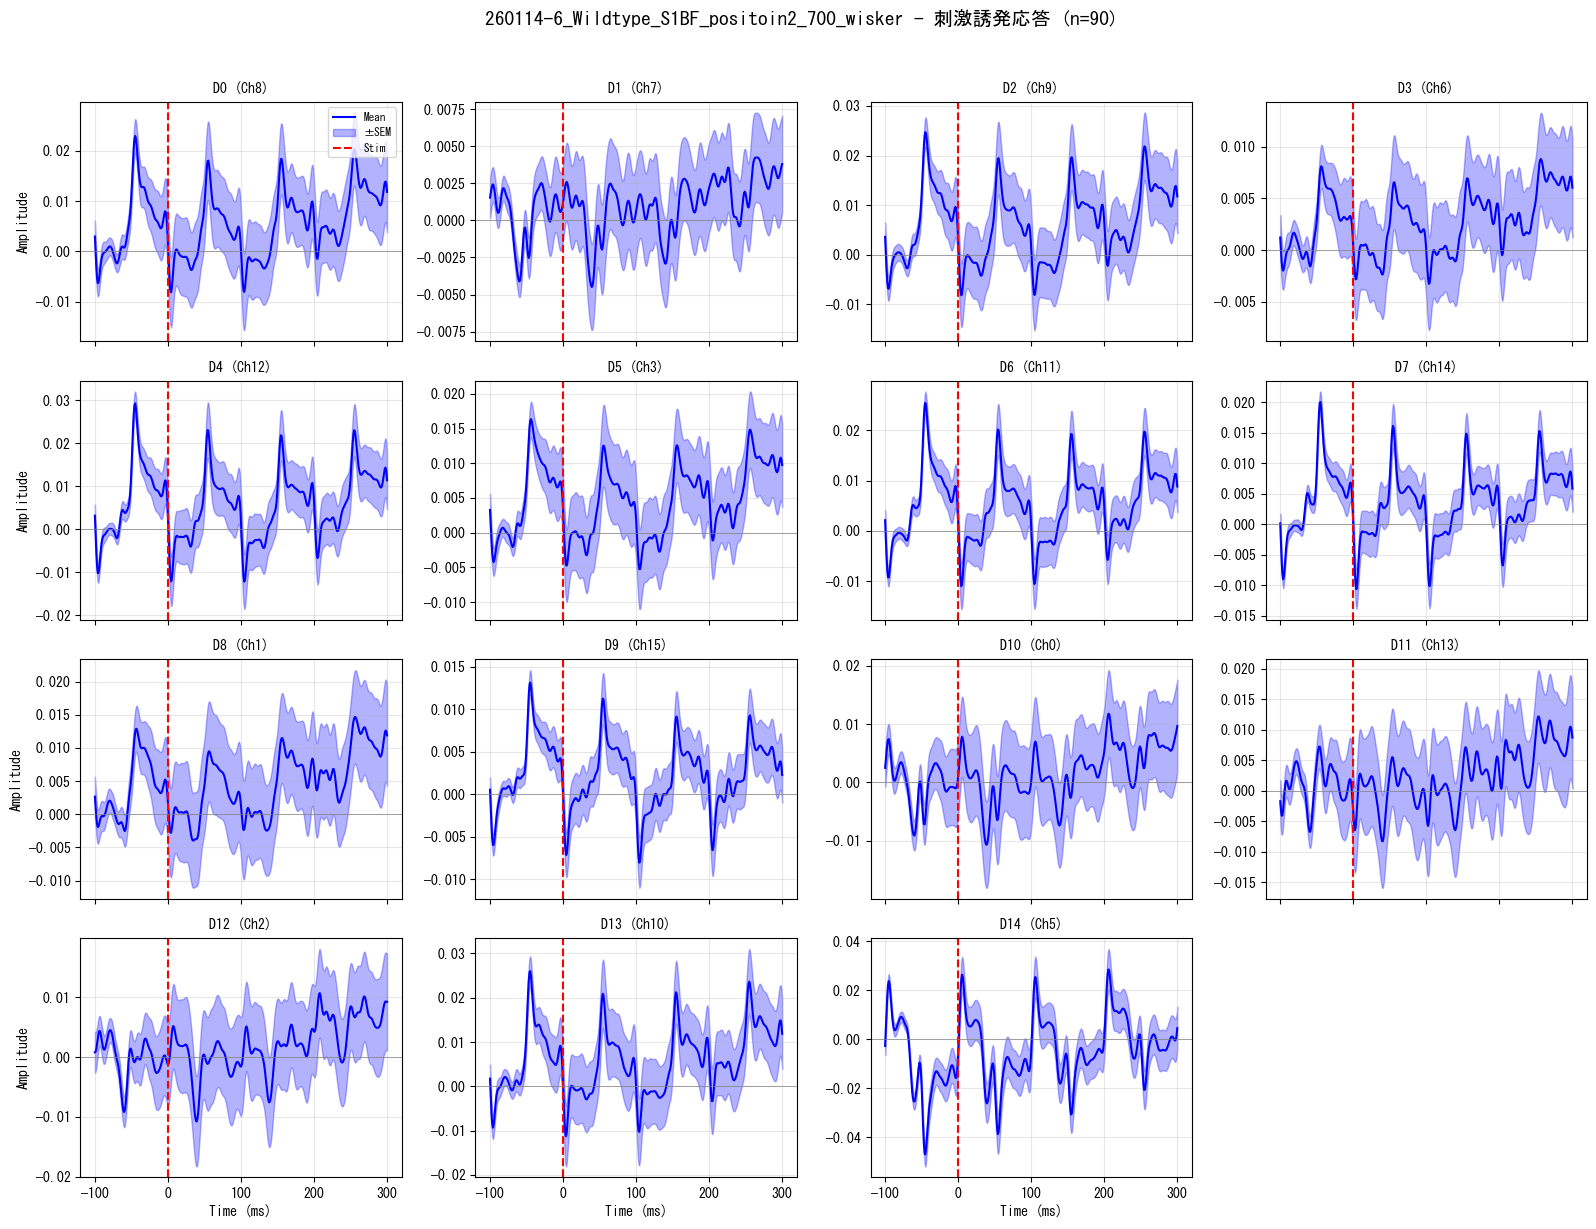

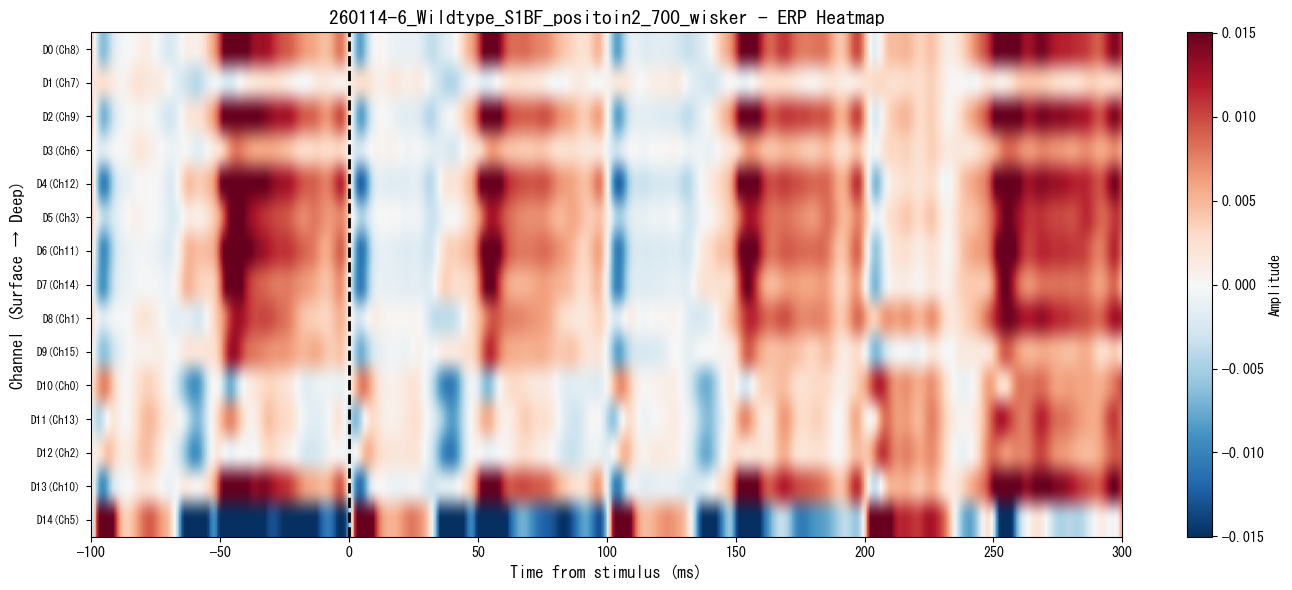

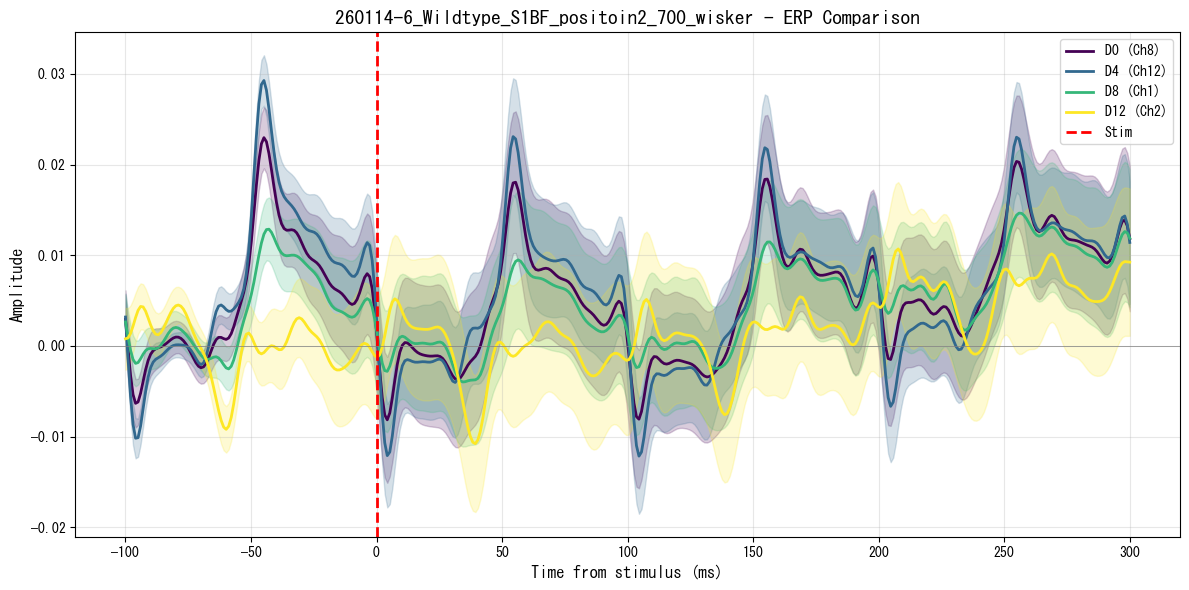

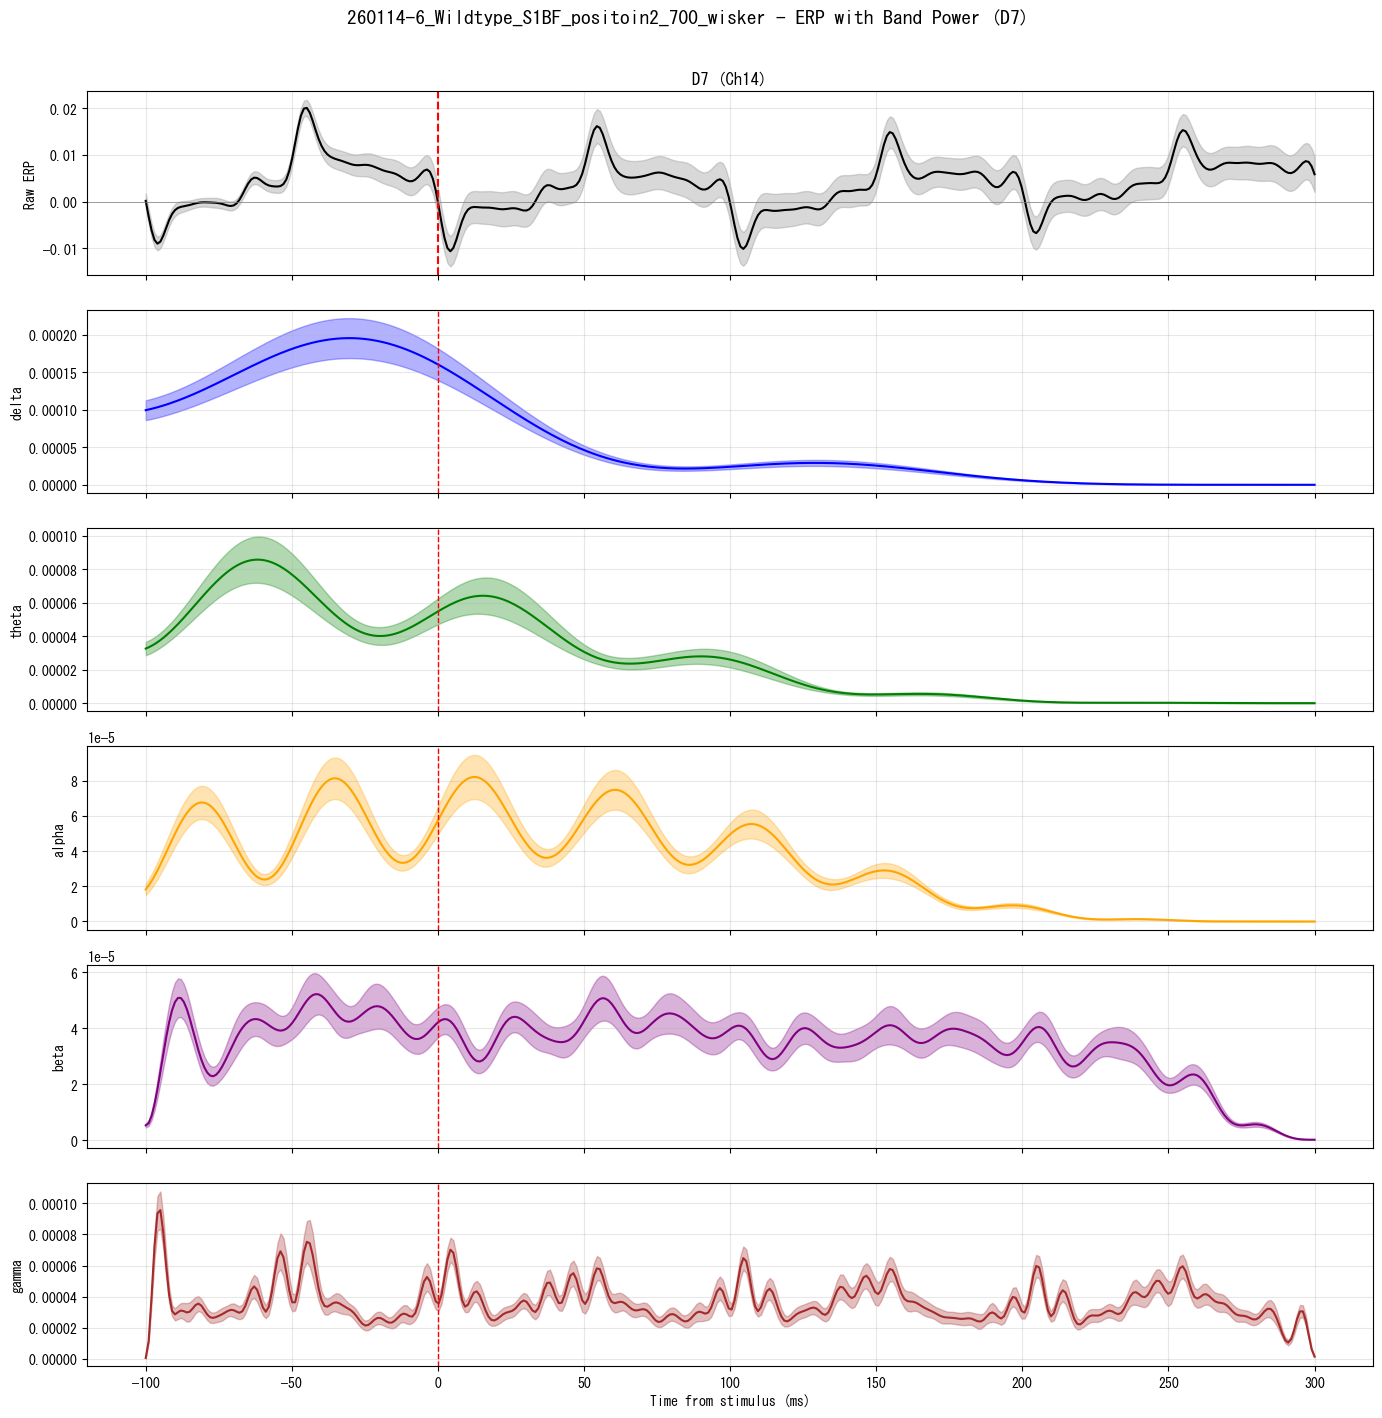

In [55]:
# ============================================================
# 刺激誘発応答の平均化 (ERP: Event-Related Potential)
# ============================================================
# このセルをノートブックの「刺激イベント取得」セルの後に追加してください

import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

def compute_erp(lfp_data, lfp_times, stim_times, fs, 
                pre_ms=100, post_ms=300, baseline_ms=50):
    """
    刺激誘発応答（ERP）を計算
    
    Parameters:
    -----------
    lfp_data : array (samples, channels)
        LFPデータ
    lfp_times : array
        時間軸
    stim_times : array
        刺激タイミング（秒）
    fs : int
        サンプリングレート
    pre_ms : float
        刺激前の時間（ミリ秒）
    post_ms : float
        刺激後の時間（ミリ秒）
    baseline_ms : float
        ベースライン補正に使う刺激前の時間（ミリ秒）
    
    Returns:
    --------
    erp_times : array
        ERP時間軸（刺激を0とする、ミリ秒）
    erp_mean : array (time_points, channels)
        平均ERP
    erp_sem : array (time_points, channels)
        標準誤差
    erp_trials : array (n_trials, time_points, channels)
        個別試行データ
    """
    pre_samples = int(pre_ms * fs / 1000)
    post_samples = int(post_ms * fs / 1000)
    baseline_samples = int(baseline_ms * fs / 1000)
    total_samples = pre_samples + post_samples
    
    n_channels = lfp_data.shape[1]
    n_trials = len(stim_times)
    
    # 各試行のデータを切り出し
    erp_trials = []
    valid_trials = 0
    
    for stim_t in stim_times:
        # 刺激時刻に最も近いインデックスを探す
        idx = np.argmin(np.abs(lfp_times - stim_t))
        
        start_idx = idx - pre_samples
        end_idx = idx + post_samples
        
        # 範囲チェック
        if start_idx >= 0 and end_idx < len(lfp_data):
            trial_data = lfp_data[start_idx:end_idx, :].copy()
            
            # ベースライン補正（刺激前の平均を引く）
            baseline = trial_data[:baseline_samples, :].mean(axis=0)
            trial_data -= baseline
            
            erp_trials.append(trial_data)
            valid_trials += 1
    
    erp_trials = np.array(erp_trials)  # (n_trials, time_points, channels)
    
    # 平均と標準誤差
    erp_mean = np.mean(erp_trials, axis=0)
    erp_sem = np.std(erp_trials, axis=0) / np.sqrt(valid_trials)
    
    # 時間軸（ミリ秒、刺激を0とする）
    erp_times = np.linspace(-pre_ms, post_ms, total_samples)
    
    print(f"有効試行数: {valid_trials}/{n_trials}")
    
    return erp_times, erp_mean, erp_sem, erp_trials


def plot_erp_all_channels(erp_times, erp_mean, erp_sem, original_ch_numbers,
                          title="刺激誘発応答 (ERP)", save_path=None):
    """
    全チャンネルのERPをプロット
    """
    n_channels = erp_mean.shape[1]
    
    fig, axes = plt.subplots(4, 4, figsize=(16, 12), sharex=True)
    axes = axes.flatten()
    
    for ch in range(n_channels):
        ax = axes[ch]
        
        # 平均波形
        ax.plot(erp_times, erp_mean[:, ch], 'b-', linewidth=1.5, label='Mean')
        
        # 標準誤差の範囲
        ax.fill_between(erp_times, 
                        erp_mean[:, ch] - erp_sem[:, ch],
                        erp_mean[:, ch] + erp_sem[:, ch],
                        alpha=0.3, color='blue', label='±SEM')
        
        # 刺激タイミング
        ax.axvline(0, color='red', linestyle='--', linewidth=1.5, label='Stim')
        ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
        
        ax.set_title(f'D{ch} (Ch{original_ch_numbers[ch]})', fontsize=10)
        ax.grid(True, alpha=0.3)
        
        if ch >= 12:
            ax.set_xlabel('Time (ms)')
        if ch % 4 == 0:
            ax.set_ylabel('Amplitude')
    
    # 空のサブプロットを非表示
    for ch in range(n_channels, 16):
        axes[ch].axis('off')
    
    # 凡例（最初のプロットに）
    axes[0].legend(loc='upper right', fontsize=8)
    
    plt.suptitle(title, fontsize=14, y=1.02)
    plt.tight_layout()
    
    if save_path:
        # plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"保存: {save_path}")
    
    plt.show()


def plot_erp_heatmap(erp_times, erp_mean, original_ch_numbers,
                     title="ERP Heatmap (全チャンネル)", save_path=None):
    """
    ERPをヒートマップで表示（深さ×時間）
    """
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # ヒートマップ
    vmax = np.percentile(np.abs(erp_mean), 95)
    im = ax.imshow(erp_mean.T, aspect='auto', cmap='RdBu_r',
                   extent=[erp_times[0], erp_times[-1], erp_mean.shape[1]-0.5, -0.5],
                   vmin=-vmax, vmax=vmax)
    
    # 刺激タイミング
    ax.axvline(0, color='black', linestyle='--', linewidth=2)
    
    ax.set_xlabel('Time from stimulus (ms)', fontsize=12)
    ax.set_ylabel('Channel (Surface → Deep)', fontsize=12)
    ax.set_yticks(range(erp_mean.shape[1]))
    ax.set_yticklabels([f'D{i}(Ch{original_ch_numbers[i]})' for i in range(erp_mean.shape[1])],
                       fontsize=8)
    
    cbar = plt.colorbar(im, ax=ax, label='Amplitude')
    
    ax.set_title(title, fontsize=14)
    plt.tight_layout()
    
    if save_path:
        # plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"保存: {save_path}")
    
    plt.show()


def plot_erp_overlay(erp_times, erp_mean, erp_sem, original_ch_numbers,
                     channels_to_plot=None, title="ERP Overlay", save_path=None):
    """
    選択したチャンネルのERPを重ねてプロット
    """
    n_channels = erp_mean.shape[1]
    
    if channels_to_plot is None:
        # デフォルト: 表層、中間、深層から選択
        channels_to_plot = [0, n_channels//3, 2*n_channels//3, n_channels-1]
        channels_to_plot = [c for c in channels_to_plot if c < n_channels]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(channels_to_plot)))
    
    for i, ch in enumerate(channels_to_plot):
        label = f'D{ch} (Ch{original_ch_numbers[ch]})'
        ax.plot(erp_times, erp_mean[:, ch], color=colors[i], 
                linewidth=2, label=label)
        ax.fill_between(erp_times,
                        erp_mean[:, ch] - erp_sem[:, ch],
                        erp_mean[:, ch] + erp_sem[:, ch],
                        alpha=0.2, color=colors[i])
    
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Stim')
    ax.axhline(0, color='gray', linestyle='-', linewidth=0.5)
    
    ax.set_xlabel('Time from stimulus (ms)', fontsize=12)
    ax.set_ylabel('Amplitude', fontsize=12)
    ax.set_title(title, fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        # plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"保存: {save_path}")
    
    plt.show()


def plot_erp_with_bands(erp_times, erp_trials, fs, original_ch_numbers,
                        channel=7, title="ERP with Band Power", save_path=None):
    """
    ERPと各周波数帯域のパワーを表示
    """
    BANDS = {
        'delta (1-4Hz)': (1, 4),
        'theta (4-8Hz)': (4, 8),
        'alpha (8-14Hz)': (8, 14),
        'beta (14-30Hz)': (14, 30),
        'gamma (30-80Hz)': (30, 80)
    }
    
    # 選択チャンネルの試行データ
    trials_ch = erp_trials[:, :, channel]  # (n_trials, time_points)
    
    fig, axes = plt.subplots(6, 1, figsize=(14, 14), sharex=True)
    
    # 1. Raw ERP
    mean_erp = trials_ch.mean(axis=0)
    sem_erp = trials_ch.std(axis=0) / np.sqrt(trials_ch.shape[0])
    
    axes[0].plot(erp_times, mean_erp, 'k-', linewidth=1.5)
    axes[0].fill_between(erp_times, mean_erp - sem_erp, mean_erp + sem_erp,
                         alpha=0.3, color='gray')
    axes[0].axvline(0, color='red', linestyle='--', linewidth=1.5)
    axes[0].axhline(0, color='gray', linestyle='-', linewidth=0.5)
    axes[0].set_ylabel('Raw ERP')
    axes[0].set_title(f'D{channel} (Ch{original_ch_numbers[channel]})')
    axes[0].grid(True, alpha=0.3)
    
    # 2-6. 各帯域
    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    
    for idx, (band_name, (low, high)) in enumerate(BANDS.items()):
        ax = axes[idx + 1]
        
        # 各試行をフィルタしてからパワー計算
        band_power_trials = []
        
        for trial in trials_ch:
            # バンドパスフィルタ
            nyq = fs / 2
            sos = signal.butter(4, [low/nyq, high/nyq], btype='bandpass', output='sos')
            filtered = signal.sosfiltfilt(sos, trial)
            # 瞬時パワー（振幅の二乗）
            power = filtered ** 2
            band_power_trials.append(power)
        
        band_power_trials = np.array(band_power_trials)
        mean_power = band_power_trials.mean(axis=0)
        sem_power = band_power_trials.std(axis=0) / np.sqrt(len(band_power_trials))
        
        ax.plot(erp_times, mean_power, color=colors[idx], linewidth=1.5)
        ax.fill_between(erp_times, mean_power - sem_power, mean_power + sem_power,
                        alpha=0.3, color=colors[idx])
        ax.axvline(0, color='red', linestyle='--', linewidth=1)
        ax.set_ylabel(band_name.split()[0])
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time from stimulus (ms)')
    
    plt.suptitle(title, fontsize=14, y=1.01)
    plt.tight_layout()
    
    if save_path:
        # plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"保存: {save_path}")
    
    plt.show()


# ============================================================
# 実行例（ノートブックで実行）
# ============================================================

# ERPを計算（刺激前100ms、刺激後300ms）
erp_times, erp_mean, erp_sem, erp_trials = compute_erp(
    lfp_cleaned,      # ICA後のLFPデータ
    lfp_times,        # 時間軸
    stim_times,       # 90個の刺激タイミング
    fs,               # サンプリングレート
    pre_ms=100,       # 刺激前 100ms
    post_ms=300,      # 刺激後 300ms
    baseline_ms=50    # ベースライン補正用 50ms
)

print(f"\nERP shape: {erp_mean.shape}")
print(f"時間範囲: {erp_times[0]:.1f}ms ~ {erp_times[-1]:.1f}ms")
# ============================================================
# ERPの可視化（上のセルの後に実行）
# ============================================================

# 1. 全チャンネルのERP（サブプロット）
plot_erp_all_channels(
    erp_times, erp_mean, erp_sem, original_ch_numbers,
    title=f'{BASENAME} - 刺激誘発応答 (n=90)',
    # save_path=os.path.join(OUTPUT_DIR, f'{BASENAME}_erp_all_channels.png')
)

# 2. ヒートマップ（深さ×時間）
plot_erp_heatmap(
    erp_times, erp_mean, original_ch_numbers,
    title=f'{BASENAME} - ERP Heatmap',
    # save_path=os.path.join(OUTPUT_DIR, f'{BASENAME}_erp_heatmap.png')
)

# 3. 代表チャンネルのオーバーレイ
plot_erp_overlay(
    erp_times, erp_mean, erp_sem, original_ch_numbers,
    channels_to_plot=[0, 4, 8, 12],  # 表層から深層まで4チャンネル
    title=f'{BASENAME} - ERP Comparison',
    # save_path=os.path.join(OUTPUT_DIR, f'{BASENAME}_erp_overlay.png')
)

# 4. 特定チャンネルのERP + 帯域パワー
plot_erp_with_bands(
    erp_times, erp_trials, fs, original_ch_numbers,
    channel=7,  # 中間層のチャンネル
    title=f'{BASENAME} - ERP with Band Power (D7)',
    # save_path=os.path.join(OUTPUT_DIR, f'{BASENAME}_erp_bands.png')
)

アーティファクト検出: 90個の刺激
テンプレート長: 105ms (105 samples)


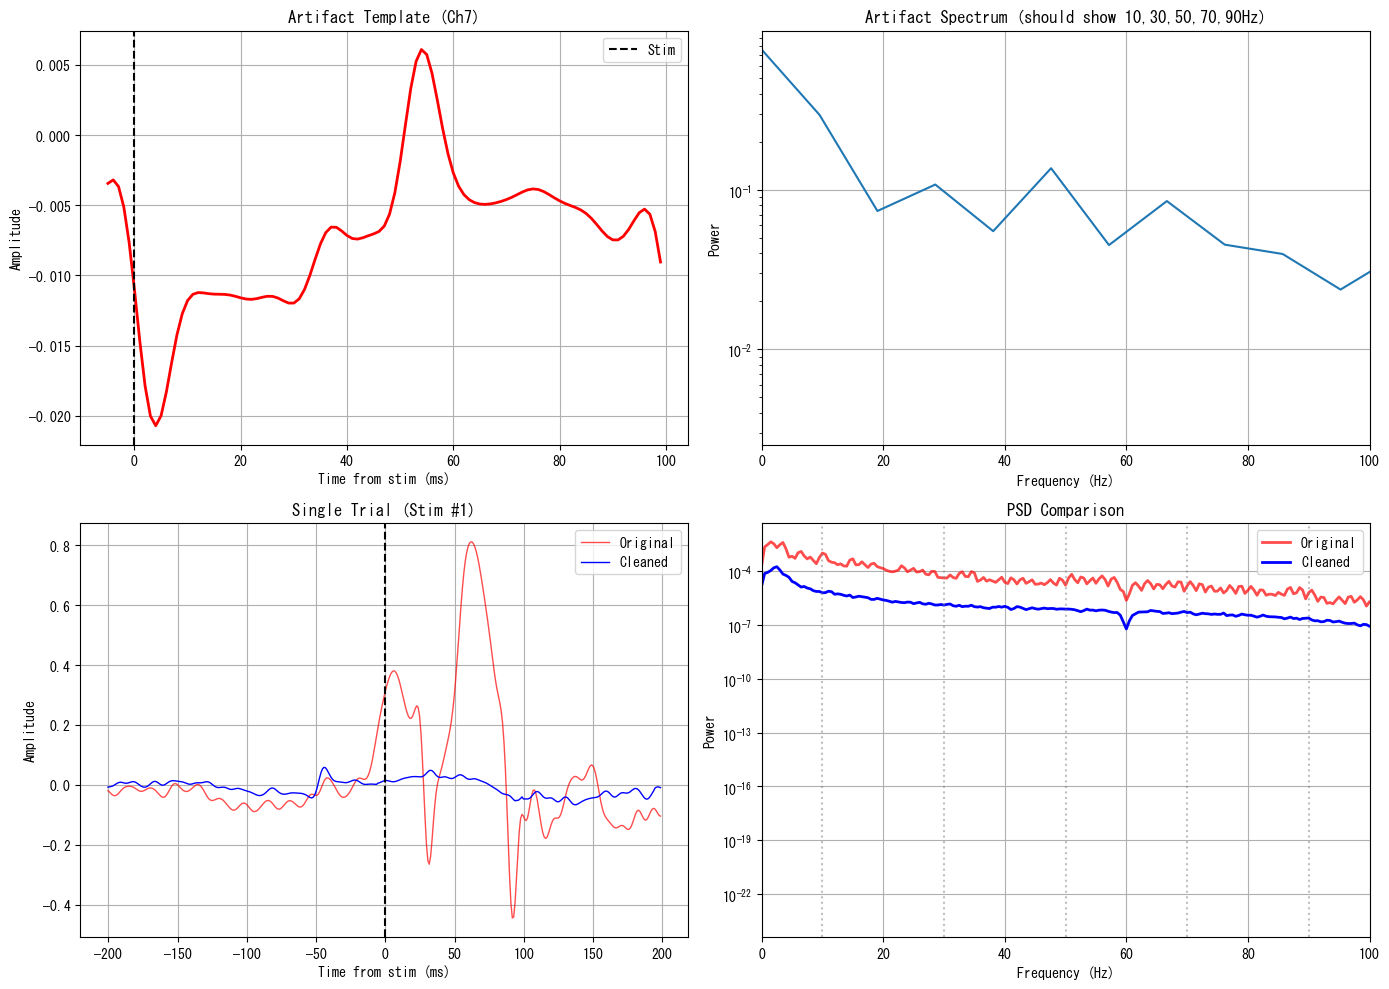

In [59]:
def remove_stim_artifact(lfp_data, lfp_times, stim_times, fs, 
                          pre_ms=5, post_ms=100, n_harmonics=5):
    """
    刺激アーティファクトをテンプレート減算で除去
    
    Parameters:
    -----------
    pre_ms : float
        刺激前の時間（ms）
    post_ms : float
        刺激後の時間（ms）- 10Hz刺激なら100msで1周期
    """
    pre_samples = int(pre_ms * fs / 1000)
    post_samples = int(post_ms * fs / 1000)
    n_channels = lfp_data.shape[1]
    
    cleaned = lfp_data.copy()
    
    # 1. 全刺激からアーティファクトを収集
    artifacts = []
    valid_indices = []
    
    for stim_t in stim_times:
        idx = np.argmin(np.abs(lfp_times - stim_t))
        start = idx - pre_samples
        end = idx + post_samples
        
        if start >= 0 and end < len(lfp_data):
            artifacts.append(lfp_data[start:end, :])
            valid_indices.append((start, end))
    
    artifacts = np.array(artifacts)  # (n_stim, time, channels)
    
    # 2. 平均テンプレートを作成
    template = np.mean(artifacts, axis=0)
    
    print(f"アーティファクト検出: {len(artifacts)}個の刺激")
    print(f"テンプレート長: {pre_ms + post_ms}ms ({template.shape[0]} samples)")
    
    # 3. 各刺激からテンプレートを減算
    for start, end in valid_indices:
        cleaned[start:end, :] -= template
    
    return cleaned, template, artifacts


def plot_artifact_removal(lfp_times, lfp_original, lfp_cleaned, template, 
                          stim_times, fs, channel=0, stim_idx=0):
    """
    アーティファクト除去の効果を可視化
    """
    pre_ms, post_ms = 5, 100
    pre_samples = int(pre_ms * fs / 1000)
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 左上: テンプレート
    template_times = np.arange(template.shape[0]) / fs * 1000 - pre_ms
    axes[0, 0].plot(template_times, template[:, channel], 'r-', lw=2)
    axes[0, 0].axvline(0, color='k', ls='--', label='Stim')
    axes[0, 0].set_xlabel('Time from stim (ms)')
    axes[0, 0].set_ylabel('Amplitude')
    axes[0, 0].set_title(f'Artifact Template (Ch{channel})')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # 右上: テンプレートのFFT
    freqs_t = np.fft.rfftfreq(len(template), 1/fs)
    fft_template = np.abs(np.fft.rfft(template[:, channel]))
    axes[0, 1].semilogy(freqs_t, fft_template)
    axes[0, 1].set_xlim(0, 100)
    axes[0, 1].set_xlabel('Frequency (Hz)')
    axes[0, 1].set_ylabel('Power')
    axes[0, 1].set_title('Artifact Spectrum (should show 10,30,50,70,90Hz)')
    axes[0, 1].grid(True)
    
    # 左下: 単一刺激の比較
    stim_t = stim_times[stim_idx]
    idx = np.argmin(np.abs(lfp_times - stim_t))
    win = int(0.2 * fs)  # 200ms window
    t_win = lfp_times[idx-win:idx+win] - stim_t
    
    axes[1, 0].plot(t_win * 1000, lfp_original[idx-win:idx+win, channel], 
                    'r-', lw=1, alpha=0.7, label='Original')
    axes[1, 0].plot(t_win * 1000, lfp_cleaned[idx-win:idx+win, channel], 
                    'b-', lw=1, label='Cleaned')
    axes[1, 0].axvline(0, color='k', ls='--')
    axes[1, 0].set_xlabel('Time from stim (ms)')
    axes[1, 0].set_ylabel('Amplitude')
    axes[1, 0].set_title(f'Single Trial (Stim #{stim_idx+1})')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # 右下: 全体のPSD比較
    f_orig, psd_orig = signal.welch(lfp_original[:, channel], fs, nperseg=fs*2)
    f_clean, psd_clean = signal.welch(lfp_cleaned[:, channel], fs, nperseg=fs*2)
    
    axes[1, 1].semilogy(f_orig, psd_orig, 'r-', lw=2, alpha=0.7, label='Original')
    axes[1, 1].semilogy(f_clean, psd_clean, 'b-', lw=2, label='Cleaned')
    axes[1, 1].set_xlim(0, 100)
    axes[1, 1].set_xlabel('Frequency (Hz)')
    axes[1, 1].set_ylabel('Power')
    axes[1, 1].set_title('PSD Comparison')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    # 高調波の位置をマーク
    for harm in [10, 30, 50, 70, 90]:
        axes[1, 1].axvline(harm, color='gray', ls=':', alpha=0.5)
    
    plt.tight_layout()
    plt.show()


# ============================================================
# 使用例（pipeline.pyに追加）
# ============================================================

# ICAの後に実行
lfp_cleaned, artifact_template, artifacts = remove_stim_artifact(
    lfp_cleaned,  # ICA後のデータ
    lfp_times,
    stim_times,
    fs,
    pre_ms=5,
    post_ms=100  # 10Hz = 100ms周期
)

# 効果を確認
plot_artifact_removal(lfp_times, lfp_filtered, lfp_cleaned, 
                      artifact_template, stim_times, fs, channel=7)


## 5.データ保存

In [28]:

# ============================================================
# データ収集
# ============================================================
import pandas as pd
data = {
    # 基本情報
    'file_name': BASENAME,
    'sampling_rate_hz': fs,
    'total_recording_sec': lfp_times_full[-1],
    'trim_start_sec': TRIM_START,
    'trim_end_sec': TRIM_END,
    'trim_duration_sec': TRIM_END - TRIM_START,
    'trim_samples': len(lfp_cleaned),
    
    # 動画・同期情報
    'video_frames': n_video_frames,
    'sync_frames': n_sync,
    'roi_x': roi[0],
    'roi_y': roi[1],
    'roi_w': roi[2],
    'roi_h': roi[3],
    
    # チャンネル情報
    'n_original_channels': 16,
    'bad_channels_depth_idx': str(bad_channels),
    'bad_channels_original': str([CHANNEL_ORDER[i] for i in bad_channels]),
    'n_bad_channels': len(bad_channels),
    'good_channels_depth_idx': str(good_channels),
    'good_channels_original': str(original_ch_numbers),
    'n_good_channels': len(good_channels),
    
    # ノイズ情報
    'noise_threshold': motion_threshold,
    'noise_ratio_percent': 100 * np.sum(noise_mask) / len(noise_mask),
    'noise_samples': np.sum(noise_mask),
    
    # ICA情報
    'ica_removed_count': len(removed_ics),
    'ica_removed_ids': str(removed_ics),
    'ica_noise_ratios': str([f'{r:.2f}' for r in noise_ratios]),
    
    # 刺激情報
    'n_sessions': n_sessions,
    'stim_per_session': n_stim_per_session,
    'total_stim': len(stim_times),
    'session_ranges': str([(f'{s:.2f}', f'{e:.2f}') for s, e in session_ranges]),
    
    # マスク割合（全体）
    'baseline_ratio_percent': 100 * np.sum(baseline_mask) / len(lfp_times),
    'stim_ratio_percent': 100 * np.sum(stim_mask) / len(lfp_times),
    'post_ratio_percent': 100 * np.sum(post_mask) / len(lfp_times),
    
    # マスク割合（クリーン）
    'clean_baseline_ratio_percent': 100 * np.sum(clean_baseline) / len(lfp_times),
    'clean_stim_ratio_percent': 100 * np.sum(clean_stim) / len(lfp_times),
    'clean_post_ratio_percent': 100 * np.sum(clean_post) / len(lfp_times),
    
    # バンドパワー（Baseline）
    'baseline_delta_power': baseline_power[0],
    'baseline_theta_power': baseline_power[1],
    'baseline_alpha_power': baseline_power[2],
    'baseline_beta_power': baseline_power[3],
    'baseline_gamma_power': baseline_power[4],
    
    # バンドパワー（Stim）
    'stim_delta_power': stim_power[0],
    'stim_theta_power': stim_power[1],
    'stim_alpha_power': stim_power[2],
    'stim_beta_power': stim_power[3],
    'stim_gamma_power': stim_power[4],
    
    # バンドパワー（Post）
    'post_delta_power': post_power[0],
    'post_theta_power': post_power[1],
    'post_alpha_power': post_power[2],
    'post_beta_power': post_power[3],
    'post_gamma_power': post_power[4],
    
    # 変化率（Stim vs Baseline）
    'stim_delta_change_percent': change_stim_list[0],
    'stim_theta_change_percent': change_stim_list[1],
    'stim_alpha_change_percent': change_stim_list[2],
    'stim_beta_change_percent': change_stim_list[3],
    'stim_gamma_change_percent': change_stim_list[4],
    
    # 変化率（Post vs Baseline）
    'post_delta_change_percent': change_post_list[0],
    'post_theta_change_percent': change_post_list[1],
    'post_alpha_change_percent': change_post_list[2],
    'post_beta_change_percent': change_post_list[3],
    'post_gamma_change_percent': change_post_list[4],
}

# ============================================================
# CSV出力
# ============================================================

df = pd.DataFrame([data])
csv_path = os.path.join(OUTPUT_DIR, f'{BASENAME}_analysis_summary.csv')
df.to_csv(csv_path, index=False)

print(f"CSV保存完了: {csv_path}")
print(f"\n=== 保存内容 ({len(data)}項目) ===")
for key, value in data.items():
    print(f"  {key}: {value}")

CSV保存完了: //nagoya_amcbnas2/wakelab7/okita/whisker_analysis/20260114-1_Wildtype_S1BF/260114-6_Wildtype_S1BF_positoin2_700_wisker\260114-6_Wildtype_S1BF_positoin2_700_wisker_analysis_summary.csv

=== 保存内容 (61項目) ===
  file_name: 260114-6_Wildtype_S1BF_positoin2_700_wisker
  sampling_rate_hz: 1000
  total_recording_sec: 115.228
  trim_start_sec: 6.31245
  trim_end_sec: 105.4925
  trim_duration_sec: 99.18005000000001
  trim_samples: 99180
  video_frames: 1241
  sync_frames: 1241
  roi_x: 524
  roi_y: 180
  roi_w: 302
  roi_h: 300
  n_original_channels: 16
  bad_channels_depth_idx: [7]
  bad_channels_original: [4]
  n_bad_channels: 1
  good_channels_depth_idx: [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15]
  good_channels_original: [8, 7, 9, 6, 12, 3, 11, 14, 1, 15, 0, 13, 2, 10, 5]
  n_good_channels: 15
  noise_threshold: 0.0
  noise_ratio_percent: 28.2637628554144
  noise_samples: 28032
  ica_removed_count: 4
  ica_removed_ids: [9, 6, 11, 1]
  ica_noise_ratios: ['3.40', '7.08', '1.93

In [29]:
# ============================================================
# チャンネル別パワーCSV出力
# ============================================================
rows = []
for ch in range(n_channels):
    for b, band in enumerate(BANDS.keys()):
        rows.append({
            'file_name': BASENAME,
            'depth_idx': ch,
            'original_ch': original_ch_numbers[ch],
            'band': band,
            'baseline_power': channel_band_power[ch, b, 0],
            'stim_power': channel_band_power[ch, b, 1],
            'post_power': channel_band_power[ch, b, 2],
            'stim_change_percent': change_stim[ch, b],
            'post_change_percent': change_post[ch, b],
        })

df_channel = pd.DataFrame(rows)
channel_csv_path = os.path.join(OUTPUT_DIR, f'{BASENAME}_channel_power.csv')
df_channel.to_csv(channel_csv_path, index=False)

print(f"チャンネル別CSV保存完了: {channel_csv_path}")
print(f"  {len(rows)}行 ({n_channels}ch × {len(BANDS)}bands)")

チャンネル別CSV保存完了: //nagoya_amcbnas2/wakelab7/okita/whisker_analysis/20260114-1_Wildtype_S1BF/260114-6_Wildtype_S1BF_positoin2_700_wisker\260114-6_Wildtype_S1BF_positoin2_700_wisker_channel_power.csv
  75行 (15ch × 5bands)


In [30]:
# ============================================================
# 結果保存
# ============================================================

# 1. 軽いデータ（グラフ再描画用）
results = {
    # メタ情報
    'params': np.array({  # dictはnp.arrayでラップ
        'roi': roi,
        'motion_threshold': motion_threshold,
        'bad_channels': bad_channels,
        'removed_ics': removed_ics,
    }),
    'good_channels': np.array(good_channels),
    'original_ch_numbers': np.array(original_ch_numbers),
    'fs': fs,
    
    # 時間・マスク
    'lfp_times': lfp_times,
    'stim_times': stim_times,
    'stim_mask': stim_mask,
    'baseline_mask': baseline_mask,
    'post_mask': post_mask,
    'noise_mask': noise_mask,
    
    # PSD
    'freqs': freqs,
    'psd_baseline': psd_baseline,
    'psd_stim': psd_stim,
    'psd_post': psd_post,
    
    # バンドパワー
    'band_names': np.array(list(BANDS.keys())),
    # 'band_results': np.array(band_results),  # dictもラップ
    'channel_band_power': channel_band_power,
    
    # 変化率（ヒートマップ用）
    'change_stim': change_stim,
    'change_post': change_post,
}
np.savez(os.path.join(OUTPUT_DIR, f'{BASENAME}_results.npz'), **results)

# 2. 重いデータ（完全再現用、ウェーブレット抜き）
processed = {
    'lfp_cleaned': lfp_cleaned,
    'lfp_filtered': lfp_filtered,
    'lfp_trimmed': lfp_trimmed,
    'motion_resampled': motion_resampled,
    'ica_sources': ica_sources,
    'noise_ratios': np.array(noise_ratios),
}
np.savez_compressed(os.path.join(OUTPUT_DIR, f'{BASENAME}_processed.npz'), **processed)

print(f"保存完了:")
print(f"  {BASENAME}_results.npz")
print(f"  {BASENAME}_processed.npz")

保存完了:
  260114-6_Wildtype_S1BF_positoin2_700_wisker_results.npz
  260114-6_Wildtype_S1BF_positoin2_700_wisker_processed.npz
